In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
sys.path.insert(0, "../src/")
import importlib
from util import ipca
from sklearn.metrics import r2_score
importlib.reload(ipca)
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import ndcg_score
import seaborn as sns

crsp_features = pd.read_csv("../data/ipca_features_final_L3Month.csv")

filepath = '/Users/jandh/Desktop/Old Desktop/od/2 Quarter/Flexible/snp1500.txt'

with open(filepath, 'r') as f:
    tickers = [line.strip() for line in f]

snp_ticker_df = pd.DataFrame(crsp_features.groupby('permno')['ticker'].apply(lambda x: x.iloc[-1]),columns=['ticker'])
snp_ticker_df = snp_ticker_df[snp_ticker_df['ticker'].isin(tickers)]

crsp_features['date'] = pd.to_datetime(crsp_features['date'])

market_df = pd.DataFrame(crsp_features.groupby('date')['vwretd'].last())

# UnComment below for only snp1500 factor fit

# crsp_features = crsp_features.loc[crsp_features.permno.isin(snp_ticker_df.index),:]
## Test Train Split (TS Test) 

crsp_features['mkt_to_book'] = crsp_features['mktcap']/crsp_features['atq']
y_column = ['ret']
x_columns = ['vol','beta','mktcap','momentum','short_term_reversal','52wk_high','price_rel_52wk_high','idvol','unexp_vol','turnover','mkt_to_book','revtq', 'niq', 'atq', 'epsfxq', 'cheq',
       'dlttq' ,'cogsq', 'oibdpq', 'cshoq']
crsp_features = crsp_features[x_columns+y_column+['date','permno']]
fund_features = ['revtq', 'niq', 'atq', 'epsfxq', 'cheq',
       'dlttq', 'cogsq', 'oibdpq', 'cshoq']

def rankNormalize(group):

    all_columns = list(group.columns)
    exclude_columns = ['permno', 'date','ret']
    
    # columns to normalize
    columns_to_normalize = [col for col in all_columns if col not in exclude_columns]
    
    result = group.copy()
    
    # Apply rank normalization only to the columns that need it
    result[columns_to_normalize] = (
        group[columns_to_normalize].rank(axis=0, method='average') / 
        (group[columns_to_normalize].count())
    ) - 0.5
    
    # Return the dataframe with all columns
    return result
result = crsp_features.groupby('date').apply(rankNormalize).reset_index(level=0, drop=True)


def lag_returns(group):
    return group['ret'].shift(-1)


result['lagged_ret'] = result.groupby('permno').apply(lag_returns).reset_index(level=0, drop=True)

result.drop(columns=['ret'],inplace=True)

y_column = ['lagged_ret']
result = result[~np.any(np.isnan(result), axis=1)]

crsp_features = result.set_index(["permno", "date"])

crsp_features = crsp_features[crsp_features.index.get_level_values(1)>pd.to_datetime('1994-01-01')]

    

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10080/3206257688.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = crsp_features.groupby('date').apply(rankNormalize).reset_index(level=0, drop=True)
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10080/3206257688.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result['lagged_ret'] = result.groupby('permno').apply(lag_re

In [2]:
test_date_start = pd.to_datetime("2018-01-01")

In [3]:
crsp_features_train = crsp_features.loc[crsp_features.index.get_level_values(1)<test_date_start]
crsp_features_test = crsp_features.loc[crsp_features.index.get_level_values(1)>=test_date_start]

# Test only on S&P Stocks

In [4]:
y_test = crsp_features_test.loc[:,y_column]
y_test = y_test.loc[y_test.index.get_level_values(0).isin(snp_ticker_df.index),y_column]

In [5]:
y_test.index.get_level_values(1).unique()

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30',
               '2018-05-31', '2018-06-29', '2018-07-31', '2018-08-31',
               '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30',
               '2019-05-31', '2019-06-28', '2019-07-31', '2019-08-30',
               '2019-09-30', '2019-10-31', '2019-11-29', '2019-12-31',
               '2020-01-31', '2020-02-28', '2020-03-31', '2020-04-30',
               '2020-05-29', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-30', '2020-11-30', '2020-12-31',
               '2021-01-29', '2021-02-26', '2021-03-31', '2021-04-30',
               '2021-05-28', '2021-06-30', '2021-07-30', '2021-08-31',
               '2021-09-30', '2021-10-29', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
      

In [6]:
n_factors = 5

In [7]:
factor_df = []
dfs = []
for date in tqdm(y_test.index.get_level_values(1).unique()):
    X = crsp_features.loc[crsp_features.index.get_level_values(1)<date].loc[:,x_columns]
    y = crsp_features.loc[crsp_features.index.get_level_values(1)<date].loc[:,y_column]
    model = ipca.InstrumentedPCA(n_factors=n_factors, intercept=False)
    model = model.fit(X = X,y=y)
    Gamma, Factors = model.get_factors(label_ind=True)
    print(date, model.score(X,y))
    predictive_factors = np.mean(Factors.values,axis=1).reshape((-1,1))

    X_current = crsp_features.loc[crsp_features.index.get_level_values(1)==date].loc[:,x_columns]
    X_current = X_current.loc[X_current.index.get_level_values(0).isin(snp_ticker_df.index),x_columns]
    y_pred = np.squeeze(X_current.dot(Gamma).dot(predictive_factors))
    dfs+= [y_pred]
    factor_df+=[predictive_factors]
    


The panel dimensions are:
n_samples: 11176 , L: 20 , T: 288


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0809252821896371
Step 2 - Aggregate Update: 1.2429643848890755
Step 3 - Aggregate Update: 0.1351289417154303
Step 4 - Aggregate Update: 0.34709838154072337
Step 5 - Aggregate Update: 1.5870699837245494
Step 6 - Aggregate Update: 0.2598379022260339
Step 7 - Aggregate Update: 0.21645512973477388
Step 8 - Aggregate Update: 0.16371210048463375
Step 9 - Aggregate Update: 0.11212216969461919
Step 10 - Aggregate Update: 0.06931182706306581
Step 11 - Aggregate Update: 0.038755027693844805
Step 12 - Aggregate Update: 0.021047287153562792
Step 13 - Aggregate Update: 0.011433944953690177
Step 14 - Aggregate Update: 0.006824954874877692
Step 15 - Aggregate Update: 0.004230286293856134
Step 16 - Aggregate Update: 0.002634958837511442
Step 17 - Aggregate Update: 0.001650825135036088
Step 18 - Aggregate Update: 0.0010412322708131527
Step 19 - Aggregate Update: 0.0006618969617562809
Step 20 - Aggregate Update: 0.00042461073750904577
Step 21 - Aggregate Update: 0.0002752792

  1%|          | 1/83 [00:11<15:57, 11.67s/it]

2018-01-31 00:00:00 0.09070973964130591


The panel dimensions are:
n_samples: 11191 , L: 20 , T: 289


[========================================================================] 100%


Step 1 - Aggregate Update: 1.078981270902821
Step 2 - Aggregate Update: 1.239647684365515
Step 3 - Aggregate Update: 0.13318973950460328
Step 4 - Aggregate Update: 0.33225260690091785
Step 5 - Aggregate Update: 1.6032260467929742
Step 6 - Aggregate Update: 0.2673297500356565
Step 7 - Aggregate Update: 0.20990636354336806
Step 8 - Aggregate Update: 0.15466612732099802
Step 9 - Aggregate Update: 0.10798591843183086
Step 10 - Aggregate Update: 0.07295623666827493
Step 11 - Aggregate Update: 0.0433390884126303
Step 12 - Aggregate Update: 0.02393617750443282
Step 13 - Aggregate Update: 0.012936376005974082
Step 14 - Aggregate Update: 0.007084326055842777
Step 15 - Aggregate Update: 0.004414523411783167
Step 16 - Aggregate Update: 0.002769147046462278
Step 17 - Aggregate Update: 0.0017507513416089304
Step 18 - Aggregate Update: 0.0011170003275493001
Step 19 - Aggregate Update: 0.0007201532293985569
Step 20 - Aggregate Update: 0.00046986769852905286
Step 21 - Aggregate Update: 0.0003106998743

  2%|▏         | 2/83 [00:23<15:35, 11.55s/it]

2018-02-28 00:00:00 0.0908967421217638


The panel dimensions are:
n_samples: 11197 , L: 20 , T: 290


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0779439185603688
Step 2 - Aggregate Update: 1.2744826767137811
Step 3 - Aggregate Update: 0.13119650649246983
Step 4 - Aggregate Update: 0.370455996230254
Step 5 - Aggregate Update: 0.2407637281164382
Step 6 - Aggregate Update: 1.570124841925745
Step 7 - Aggregate Update: 0.21224374759835823
Step 8 - Aggregate Update: 0.1932453541752716
Step 9 - Aggregate Update: 0.1340542336106839
Step 10 - Aggregate Update: 0.09457924488940478
Step 11 - Aggregate Update: 0.06095418918687165
Step 12 - Aggregate Update: 0.034706441894402446
Step 13 - Aggregate Update: 0.01885151362474788
Step 14 - Aggregate Update: 0.01012429229268023
Step 15 - Aggregate Update: 0.0060009415204983485
Step 16 - Aggregate Update: 0.0037249325124053545
Step 17 - Aggregate Update: 0.0023268238642705774
Step 18 - Aggregate Update: 0.001464339208382237
Step 19 - Aggregate Update: 0.0009295535473664851
Step 20 - Aggregate Update: 0.0005960060221200658
Step 21 - Aggregate Update: 0.0003865512848816

  4%|▎         | 3/83 [00:34<15:26, 11.58s/it]

2018-03-29 00:00:00 0.09072902045655107


The panel dimensions are:
n_samples: 11210 , L: 20 , T: 291


[========================================================================] 100%


Step 1 - Aggregate Update: 1.076277420855292
Step 2 - Aggregate Update: 1.2609806393997958
Step 3 - Aggregate Update: 0.13233742224615788
Step 4 - Aggregate Update: 0.13877628782187257
Step 5 - Aggregate Update: 0.20282832519153055
Step 6 - Aggregate Update: 1.5698805880692033
Step 7 - Aggregate Update: 0.3422481515914798
Step 8 - Aggregate Update: 0.2224683479051876
Step 9 - Aggregate Update: 0.16036225269852128
Step 10 - Aggregate Update: 0.10659717653607359
Step 11 - Aggregate Update: 0.06934375443877101
Step 12 - Aggregate Update: 0.041176849158680584
Step 13 - Aggregate Update: 0.02309371571635279
Step 14 - Aggregate Update: 0.012663377450210695
Step 15 - Aggregate Update: 0.007258993778685524
Step 16 - Aggregate Update: 0.004511678700381078
Step 17 - Aggregate Update: 0.0028279123452297494
Step 18 - Aggregate Update: 0.0017897008400250547
Step 19 - Aggregate Update: 0.0011450109748405435
Step 20 - Aggregate Update: 0.0007415454001623578
Step 21 - Aggregate Update: 0.0004868221494

  5%|▍         | 4/83 [00:46<15:19, 11.64s/it]

2018-04-30 00:00:00 0.089972046942695


The panel dimensions are:
n_samples: 11227 , L: 20 , T: 292


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0730985340968302
Step 2 - Aggregate Update: 1.2836313514059698
Step 3 - Aggregate Update: 0.1303044921502005
Step 4 - Aggregate Update: 0.25891485315592555
Step 5 - Aggregate Update: 1.5748738593980436
Step 6 - Aggregate Update: 0.2964960881242231
Step 7 - Aggregate Update: 0.21508190785032727
Step 8 - Aggregate Update: 0.15227524632256656
Step 9 - Aggregate Update: 0.10555067349022641
Step 10 - Aggregate Update: 0.06910008622225047
Step 11 - Aggregate Update: 0.03981310577591452
Step 12 - Aggregate Update: 0.021707174835298517
Step 13 - Aggregate Update: 0.011690239676800803
Step 14 - Aggregate Update: 0.006250324800220801
Step 15 - Aggregate Update: 0.0037636087284958764
Step 16 - Aggregate Update: 0.002298182871349752
Step 17 - Aggregate Update: 0.0014156949882377923
Step 18 - Aggregate Update: 0.0008806423029303345
Step 19 - Aggregate Update: 0.0005538736290919555
Step 20 - Aggregate Update: 0.0003526981572259391
Step 21 - Aggregate Update: 0.0002277115

  6%|▌         | 5/83 [00:58<15:12, 11.70s/it]

2018-05-31 00:00:00 0.09000038654361175


The panel dimensions are:
n_samples: 11235 , L: 20 , T: 293


[========================================================================] 100%


Step 1 - Aggregate Update: 1.072108595865864
Step 2 - Aggregate Update: 1.2923156534322686
Step 3 - Aggregate Update: 0.1245216467461186
Step 4 - Aggregate Update: 0.2849525086808723
Step 5 - Aggregate Update: 1.5746475920508147
Step 6 - Aggregate Update: 0.2643280975474858
Step 7 - Aggregate Update: 0.21555416093892354
Step 8 - Aggregate Update: 0.1569697758406028
Step 9 - Aggregate Update: 0.11085624668924096
Step 10 - Aggregate Update: 0.0680289552377842
Step 11 - Aggregate Update: 0.03648616490853125
Step 12 - Aggregate Update: 0.019058298885350045
Step 13 - Aggregate Update: 0.010390455020857392
Step 14 - Aggregate Update: 0.006166249163118531
Step 15 - Aggregate Update: 0.003746704166338738
Step 16 - Aggregate Update: 0.002297923855345607
Step 17 - Aggregate Update: 0.0014239913214668387
Step 18 - Aggregate Update: 0.0008925962565795031
Step 19 - Aggregate Update: 0.0005666880269345753
Step 20 - Aggregate Update: 0.0003648913428138667
Step 21 - Aggregate Update: 0.000238593095748

  7%|▋         | 6/83 [01:10<15:04, 11.74s/it]

2018-06-29 00:00:00 0.08952942372271422


The panel dimensions are:
n_samples: 11252 , L: 20 , T: 294


[========================================================================] 100%


Step 1 - Aggregate Update: 1.072244257671978
Step 2 - Aggregate Update: 1.2922686856006524
Step 3 - Aggregate Update: 0.1267362038155828
Step 4 - Aggregate Update: 0.31620766149010726
Step 5 - Aggregate Update: 1.564162111754892
Step 6 - Aggregate Update: 0.23566356964392324
Step 7 - Aggregate Update: 0.20800676330733914
Step 8 - Aggregate Update: 0.14980694939062295
Step 9 - Aggregate Update: 0.10530427382932034
Step 10 - Aggregate Update: 0.06372196764678403
Step 11 - Aggregate Update: 0.034175169620571766
Step 12 - Aggregate Update: 0.017955442589692883
Step 13 - Aggregate Update: 0.00962153170148114
Step 14 - Aggregate Update: 0.005666494772138014
Step 15 - Aggregate Update: 0.0034331256280647204
Step 16 - Aggregate Update: 0.002098517727640331
Step 17 - Aggregate Update: 0.0012952913955835144
Step 18 - Aggregate Update: 0.0008082076137433947
Step 19 - Aggregate Update: 0.0005104306478097564
Step 20 - Aggregate Update: 0.00032674385744094203
Step 21 - Aggregate Update: 0.0002122800

  8%|▊         | 7/83 [01:22<14:56, 11.79s/it]

2018-07-31 00:00:00 0.08940548509107282


The panel dimensions are:
n_samples: 11266 , L: 20 , T: 295


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0701842485803055
Step 2 - Aggregate Update: 1.3168825495737986
Step 3 - Aggregate Update: 0.24567040462090917
Step 4 - Aggregate Update: 1.5765441443305446
Step 5 - Aggregate Update: 0.21887983104750863
Step 6 - Aggregate Update: 0.2044065858864128
Step 7 - Aggregate Update: 0.1531179219817935
Step 8 - Aggregate Update: 0.15142983071611943
Step 9 - Aggregate Update: 0.13470593299156786
Step 10 - Aggregate Update: 0.052067515465262476
Step 11 - Aggregate Update: 0.021227067195300584
Step 12 - Aggregate Update: 0.012225982819863895
Step 13 - Aggregate Update: 0.007161216642838836
Step 14 - Aggregate Update: 0.004313241032627979
Step 15 - Aggregate Update: 0.002623830106785352
Step 16 - Aggregate Update: 0.0016134895512925906
Step 17 - Aggregate Update: 0.001003944726116257
Step 18 - Aggregate Update: 0.0006327823539143407
Step 19 - Aggregate Update: 0.00040449743835344054
Step 20 - Aggregate Update: 0.0003257339235911427
Step 21 - Aggregate Update: 0.00025919

 10%|▉         | 8/83 [01:33<14:46, 11.82s/it]

2018-08-31 00:00:00 0.08936118467796417


The panel dimensions are:
n_samples: 11282 , L: 20 , T: 296


[========================================================================] 100%


Step 1 - Aggregate Update: 1.070221033703167
Step 2 - Aggregate Update: 1.322444889182775
Step 3 - Aggregate Update: 0.2513962107073138
Step 4 - Aggregate Update: 1.5932578422792854
Step 5 - Aggregate Update: 0.23321985161674433
Step 6 - Aggregate Update: 0.20468403537677649
Step 7 - Aggregate Update: 0.1513792287434071
Step 8 - Aggregate Update: 0.14937438795185343
Step 9 - Aggregate Update: 0.15440354971790263
Step 10 - Aggregate Update: 0.05860314387592433
Step 11 - Aggregate Update: 0.022639022781469995
Step 12 - Aggregate Update: 0.012415907879180288
Step 13 - Aggregate Update: 0.00719031560231137
Step 14 - Aggregate Update: 0.004284312004432189
Step 15 - Aggregate Update: 0.0025873835143349067
Step 16 - Aggregate Update: 0.0015777153410968803
Step 17 - Aggregate Update: 0.0009722613494564103
Step 18 - Aggregate Update: 0.0006062204421710959
Step 19 - Aggregate Update: 0.000382959311140435
Step 20 - Aggregate Update: 0.00025200909452030573
Step 21 - Aggregate Update: 0.00020150527

 11%|█         | 9/83 [01:45<14:37, 11.86s/it]

2018-09-28 00:00:00 0.08928314721592856


The panel dimensions are:
n_samples: 11310 , L: 20 , T: 297


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0638310962163169
Step 2 - Aggregate Update: 1.2846324099576556
Step 3 - Aggregate Update: 0.4569341643584074
Step 4 - Aggregate Update: 1.616392462940527
Step 5 - Aggregate Update: 0.18926942226763055
Step 6 - Aggregate Update: 0.1991945334109982
Step 7 - Aggregate Update: 0.15750380304144554
Step 8 - Aggregate Update: 0.1310247496390147
Step 9 - Aggregate Update: 0.09271310027628524
Step 10 - Aggregate Update: 0.049119407873304016
Step 11 - Aggregate Update: 0.024891303170106814
Step 12 - Aggregate Update: 0.013072527605669917
Step 13 - Aggregate Update: 0.0070388757439176775
Step 14 - Aggregate Update: 0.003894929958180887
Step 15 - Aggregate Update: 0.002289486274570929
Step 16 - Aggregate Update: 0.0013503249190252031
Step 17 - Aggregate Update: 0.0008209157166070014
Step 18 - Aggregate Update: 0.0005065893919767583
Step 19 - Aggregate Update: 0.0003164065491068069
Step 20 - Aggregate Update: 0.00020032222928700882
Step 21 - Aggregate Update: 0.00012875

 12%|█▏        | 10/83 [01:57<14:28, 11.90s/it]

2018-10-31 00:00:00 0.08880207947432728


The panel dimensions are:
n_samples: 11327 , L: 20 , T: 298


[========================================================================] 100%


Step 1 - Aggregate Update: 1.064261272178119
Step 2 - Aggregate Update: 1.2924795238655742
Step 3 - Aggregate Update: 0.5277803093341552
Step 4 - Aggregate Update: 1.599427281104614
Step 5 - Aggregate Update: 0.19146266706089654
Step 6 - Aggregate Update: 0.19267964814525362
Step 7 - Aggregate Update: 0.1519765616085981
Step 8 - Aggregate Update: 0.13112914150638438
Step 9 - Aggregate Update: 0.08895171774873575
Step 10 - Aggregate Update: 0.04509255258769278
Step 11 - Aggregate Update: 0.02247422346550531
Step 12 - Aggregate Update: 0.011692746862383058
Step 13 - Aggregate Update: 0.006231656562623242
Step 14 - Aggregate Update: 0.0036512256625238215
Step 15 - Aggregate Update: 0.0022170810433759514
Step 16 - Aggregate Update: 0.0013577790836905301
Step 17 - Aggregate Update: 0.000839365632007788
Step 18 - Aggregate Update: 0.0005243463009520499
Step 19 - Aggregate Update: 0.00033141720310439493
Step 20 - Aggregate Update: 0.00021222284542649072
Step 21 - Aggregate Update: 0.000137850

 13%|█▎        | 11/83 [02:09<14:19, 11.94s/it]

2018-11-30 00:00:00 0.08862868867013118


The panel dimensions are:
n_samples: 11335 , L: 20 , T: 299


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0611934458095915
Step 2 - Aggregate Update: 1.3003393129004333
Step 3 - Aggregate Update: 0.4826268168025841
Step 4 - Aggregate Update: 1.6414417296858428
Step 5 - Aggregate Update: 0.18873397542002218
Step 6 - Aggregate Update: 0.1966053007995775
Step 7 - Aggregate Update: 0.15997292793627022
Step 8 - Aggregate Update: 0.16491689050155342
Step 9 - Aggregate Update: 0.12729099667070604
Step 10 - Aggregate Update: 0.05093007884076687
Step 11 - Aggregate Update: 0.022536193984413103
Step 12 - Aggregate Update: 0.011242394528176436
Step 13 - Aggregate Update: 0.006285993588257405
Step 14 - Aggregate Update: 0.003655467167657467
Step 15 - Aggregate Update: 0.0021378567410221816
Step 16 - Aggregate Update: 0.0012814670593482291
Step 17 - Aggregate Update: 0.0007737716502947689
Step 18 - Aggregate Update: 0.0004710465286147103
Step 19 - Aggregate Update: 0.00028942903284454036
Step 20 - Aggregate Update: 0.00017972722667639052
Step 21 - Aggregate Update: 0.000112

 14%|█▍        | 12/83 [02:22<14:16, 12.06s/it]

2018-12-31 00:00:00 0.0896838161768041


The panel dimensions are:
n_samples: 11345 , L: 20 , T: 300


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0496158958613706
Step 2 - Aggregate Update: 1.3092531963451006
Step 3 - Aggregate Update: 1.4954639065389916
Step 4 - Aggregate Update: 0.2218800790228393
Step 5 - Aggregate Update: 0.1999552615443776
Step 6 - Aggregate Update: 0.17638556010179668
Step 7 - Aggregate Update: 0.16406029279784595
Step 8 - Aggregate Update: 0.13916171876051608
Step 9 - Aggregate Update: 0.06456895949483332
Step 10 - Aggregate Update: 0.028591775815603238
Step 11 - Aggregate Update: 0.014199837125115772
Step 12 - Aggregate Update: 0.007529892696381199
Step 13 - Aggregate Update: 0.004111644084953431
Step 14 - Aggregate Update: 0.0023253511768804302
Step 15 - Aggregate Update: 0.0013215612590619374
Step 16 - Aggregate Update: 0.0007509968843668058
Step 17 - Aggregate Update: 0.00042664252029089855
Step 18 - Aggregate Update: 0.00024229861278529663
Step 19 - Aggregate Update: 0.00013756561818031865
Step 20 - Aggregate Update: 7.808272427131668e-05
Step 21 - Aggregate Update: 4.430

 16%|█▌        | 13/83 [02:34<14:03, 12.04s/it]

2019-01-31 00:00:00 0.0905177214133035


The panel dimensions are:
n_samples: 11355 , L: 20 , T: 301


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0471217646715398
Step 2 - Aggregate Update: 1.308649999394508
Step 3 - Aggregate Update: 1.4914017456399729
Step 4 - Aggregate Update: 0.21290759229505615
Step 5 - Aggregate Update: 0.19566292809421337
Step 6 - Aggregate Update: 0.1545276843412754
Step 7 - Aggregate Update: 0.17600610597788635
Step 8 - Aggregate Update: 0.20466868936882102
Step 9 - Aggregate Update: 0.05510489931825448
Step 10 - Aggregate Update: 0.020972019987341897
Step 11 - Aggregate Update: 0.011572363342548547
Step 12 - Aggregate Update: 0.006494143078563802
Step 13 - Aggregate Update: 0.0036487372099211768
Step 14 - Aggregate Update: 0.002051446421677705
Step 15 - Aggregate Update: 0.001153412500962292
Step 16 - Aggregate Update: 0.0006482510443693579
Step 17 - Aggregate Update: 0.00036412926203097107
Step 18 - Aggregate Update: 0.00020440218641751273
Step 19 - Aggregate Update: 0.00011465798975640595
Step 20 - Aggregate Update: 6.42637469473184e-05
Step 21 - Aggregate Update: 3.59823

 17%|█▋        | 14/83 [02:46<13:54, 12.10s/it]

2019-02-28 00:00:00 0.09037526754985548


The panel dimensions are:
n_samples: 11371 , L: 20 , T: 302


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0470386645400436
Step 2 - Aggregate Update: 1.3113746281864838
Step 3 - Aggregate Update: 1.5040515622018578
Step 4 - Aggregate Update: 0.2602101777208971
Step 5 - Aggregate Update: 0.19505890196341996
Step 6 - Aggregate Update: 0.13733697576762566
Step 7 - Aggregate Update: 0.09095989740149452
Step 8 - Aggregate Update: 0.1947095739956302
Step 9 - Aggregate Update: 0.18703600946066715
Step 10 - Aggregate Update: 0.0598574378382683
Step 11 - Aggregate Update: 0.022200019911445823
Step 12 - Aggregate Update: 0.010440105397834187
Step 13 - Aggregate Update: 0.005312692169116673
Step 14 - Aggregate Update: 0.0027973646750100722
Step 15 - Aggregate Update: 0.0014887671053288587
Step 16 - Aggregate Update: 0.0007910768922962386
Step 17 - Aggregate Update: 0.00041670151147832346
Step 18 - Aggregate Update: 0.000222178624438768
Step 19 - Aggregate Update: 0.00011717754802206826
Step 20 - Aggregate Update: 6.397789053769198e-05
Step 21 - Aggregate Update: 3.6152863

 18%|█▊        | 15/83 [02:58<13:50, 12.21s/it]

2019-03-29 00:00:00 0.09012802959886601


The panel dimensions are:
n_samples: 11403 , L: 20 , T: 303


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0468600324813226
Step 2 - Aggregate Update: 1.3150922097814446
Step 3 - Aggregate Update: 1.4934095255328692
Step 4 - Aggregate Update: 0.2245693498495268
Step 5 - Aggregate Update: 0.19019969599109754
Step 6 - Aggregate Update: 0.12730887325062745
Step 7 - Aggregate Update: 0.09826537216563075
Step 8 - Aggregate Update: 0.19525345044340342
Step 9 - Aggregate Update: 0.12992876576140286
Step 10 - Aggregate Update: 0.04619861379491519
Step 11 - Aggregate Update: 0.018810231919660025
Step 12 - Aggregate Update: 0.009251062835048507
Step 13 - Aggregate Update: 0.004790862002671814
Step 14 - Aggregate Update: 0.002526270122067076
Step 15 - Aggregate Update: 0.0013316711554864913
Step 16 - Aggregate Update: 0.0006933805126245196
Step 17 - Aggregate Update: 0.00035705469048225025
Step 18 - Aggregate Update: 0.0001814866148640848
Step 19 - Aggregate Update: 0.00010308356068364222
Step 20 - Aggregate Update: 6.050605028623535e-05
Step 21 - Aggregate Update: 3.62958

 19%|█▉        | 16/83 [03:11<13:40, 12.25s/it]

2019-04-30 00:00:00 0.0900351449976573


The panel dimensions are:
n_samples: 11422 , L: 20 , T: 304


[========================================================================] 100%


Step 1 - Aggregate Update: 1.04387458676435
Step 2 - Aggregate Update: 1.3041861966692696
Step 3 - Aggregate Update: 1.4767659118958423
Step 4 - Aggregate Update: 0.2514315127450662
Step 5 - Aggregate Update: 0.19527801030460845
Step 6 - Aggregate Update: 0.13001152261259563
Step 7 - Aggregate Update: 0.09538949125550752
Step 8 - Aggregate Update: 0.23197900095665874
Step 9 - Aggregate Update: 0.15346232029236773
Step 10 - Aggregate Update: 0.04337290004216893
Step 11 - Aggregate Update: 0.01762625865862638
Step 12 - Aggregate Update: 0.008393071633295557
Step 13 - Aggregate Update: 0.004323458399263236
Step 14 - Aggregate Update: 0.002308478554475968
Step 15 - Aggregate Update: 0.001261048434571671
Step 16 - Aggregate Update: 0.0006979142816824491
Step 17 - Aggregate Update: 0.00038801418859515935
Step 18 - Aggregate Update: 0.0002167932544439033
Step 19 - Aggregate Update: 0.00012196060046029689
Step 20 - Aggregate Update: 6.928792000723827e-05
Step 21 - Aggregate Update: 3.990283208

 20%|██        | 17/83 [03:23<13:32, 12.32s/it]

2019-05-31 00:00:00 0.09061086456458867


The panel dimensions are:
n_samples: 11438 , L: 20 , T: 305


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0422956812928341
Step 2 - Aggregate Update: 1.2923333679486666
Step 3 - Aggregate Update: 1.4381189631932751
Step 4 - Aggregate Update: 0.21337859129732314
Step 5 - Aggregate Update: 0.17502266522344323
Step 6 - Aggregate Update: 0.10991340257249832
Step 7 - Aggregate Update: 0.12804459973700685
Step 8 - Aggregate Update: 0.22413246239565884
Step 9 - Aggregate Update: 0.08363854880054586
Step 10 - Aggregate Update: 0.02831605487133587
Step 11 - Aggregate Update: 0.0127116795546795
Step 12 - Aggregate Update: 0.006368193804385414
Step 13 - Aggregate Update: 0.003361791672112535
Step 14 - Aggregate Update: 0.0018156891778055018
Step 15 - Aggregate Update: 0.0009925262790483613
Step 16 - Aggregate Update: 0.000547159010884507
Step 17 - Aggregate Update: 0.0003024260292922576
Step 18 - Aggregate Update: 0.00016766990609015653
Step 19 - Aggregate Update: 9.338267965597336e-05
Step 20 - Aggregate Update: 5.236443047082484e-05
Step 21 - Aggregate Update: 2.9650883

 22%|██▏       | 18/83 [03:36<13:25, 12.39s/it]

2019-06-28 00:00:00 0.09073442370808349


The panel dimensions are:
n_samples: 11450 , L: 20 , T: 306


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0424481589769212
Step 2 - Aggregate Update: 1.2897760225260044
Step 3 - Aggregate Update: 1.4299655061797847
Step 4 - Aggregate Update: 0.2135365445388293
Step 5 - Aggregate Update: 0.1760991510545667
Step 6 - Aggregate Update: 0.11297955831821593
Step 7 - Aggregate Update: 0.13617108740746667
Step 8 - Aggregate Update: 0.2033587111866685
Step 9 - Aggregate Update: 0.07756020479911913
Step 10 - Aggregate Update: 0.027387166272832053
Step 11 - Aggregate Update: 0.012577493723645972
Step 12 - Aggregate Update: 0.006354229111155907
Step 13 - Aggregate Update: 0.0033613264590655056
Step 14 - Aggregate Update: 0.0018132581416544502
Step 15 - Aggregate Update: 0.0009918272753451085
Step 16 - Aggregate Update: 0.0005436607347959754
Step 17 - Aggregate Update: 0.00029806740447460567
Step 18 - Aggregate Update: 0.0001633884597474211
Step 19 - Aggregate Update: 8.957664172740132e-05
Step 20 - Aggregate Update: 4.915788776854724e-05
Step 21 - Aggregate Update: 2.70368

 23%|██▎       | 19/83 [03:48<13:16, 12.44s/it]

2019-07-31 00:00:00 0.09061183890061009


The panel dimensions are:
n_samples: 11463 , L: 20 , T: 307


[========================================================================] 100%


Step 1 - Aggregate Update: 1.043555099688368
Step 2 - Aggregate Update: 1.2536651852418723
Step 3 - Aggregate Update: 1.2997494742459619
Step 4 - Aggregate Update: 0.21265114980739808
Step 5 - Aggregate Update: 0.16829744704622351
Step 6 - Aggregate Update: 0.10752879518246261
Step 7 - Aggregate Update: 0.14002619091959823
Step 8 - Aggregate Update: 0.1682679440277628
Step 9 - Aggregate Update: 0.06809747054790435
Step 10 - Aggregate Update: 0.027787485256909494
Step 11 - Aggregate Update: 0.013063780212687837
Step 12 - Aggregate Update: 0.0065023617647670395
Step 13 - Aggregate Update: 0.003273157757237799
Step 14 - Aggregate Update: 0.0016058617773141437
Step 15 - Aggregate Update: 0.0007471474887938978
Step 16 - Aggregate Update: 0.0004609507309122074
Step 17 - Aggregate Update: 0.00029140406317554324
Step 18 - Aggregate Update: 0.00018880652570740786
Step 19 - Aggregate Update: 0.00015203835770105645
Step 20 - Aggregate Update: 0.00012579953484589956
Step 21 - Aggregate Update: 0.0

 24%|██▍       | 20/83 [04:01<13:10, 12.55s/it]

2019-08-30 00:00:00 0.09058378453447458


The panel dimensions are:
n_samples: 11480 , L: 20 , T: 308


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0426306131776553
Step 2 - Aggregate Update: 1.2719239379727165
Step 3 - Aggregate Update: 1.3036305907018928
Step 4 - Aggregate Update: 0.21538306108731609
Step 5 - Aggregate Update: 0.17184239714346128
Step 6 - Aggregate Update: 0.11429942173771135
Step 7 - Aggregate Update: 0.11726835704477548
Step 8 - Aggregate Update: 0.11436257927081071
Step 9 - Aggregate Update: 0.05547568188764754
Step 10 - Aggregate Update: 0.02461446425766839
Step 11 - Aggregate Update: 0.012263524577434626
Step 12 - Aggregate Update: 0.006157485188267198
Step 13 - Aggregate Update: 0.0030265927096151946
Step 14 - Aggregate Update: 0.001399680721815233
Step 15 - Aggregate Update: 0.0007372086168583036
Step 16 - Aggregate Update: 0.0004554367169977702
Step 17 - Aggregate Update: 0.00028840482080158547
Step 18 - Aggregate Update: 0.000216201422178236
Step 19 - Aggregate Update: 0.00020416667564876478
Step 20 - Aggregate Update: 0.00017757073068408458
Step 21 - Aggregate Update: 0.000

 25%|██▌       | 21/83 [04:15<13:13, 12.80s/it]

2019-09-30 00:00:00 0.0906029757432314


The panel dimensions are:
n_samples: 11504 , L: 20 , T: 309


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0425921072034439
Step 2 - Aggregate Update: 1.2761482413812506
Step 3 - Aggregate Update: 1.3029762839745984
Step 4 - Aggregate Update: 0.21330705325265698
Step 5 - Aggregate Update: 0.16475480937480141
Step 6 - Aggregate Update: 0.10640342206417797
Step 7 - Aggregate Update: 0.1379361086830754
Step 8 - Aggregate Update: 0.14790336169645035
Step 9 - Aggregate Update: 0.06039754074326817
Step 10 - Aggregate Update: 0.026344551765063562
Step 11 - Aggregate Update: 0.01253592183845964
Step 12 - Aggregate Update: 0.006236932256863059
Step 13 - Aggregate Update: 0.0031097466721760614
Step 14 - Aggregate Update: 0.0014965787921690787
Step 15 - Aggregate Update: 0.0007031310762383725
Step 16 - Aggregate Update: 0.00043210191741963055
Step 17 - Aggregate Update: 0.0002721058875344573
Step 18 - Aggregate Update: 0.00017998059993523663
Step 19 - Aggregate Update: 0.00015412740306020023
Step 20 - Aggregate Update: 0.0001274262736101206
Step 21 - Aggregate Update: 0.00

 27%|██▋       | 22/83 [04:28<13:04, 12.86s/it]

2019-10-31 00:00:00 0.09049154326390207


The panel dimensions are:
n_samples: 11526 , L: 20 , T: 310


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0413468293778312
Step 2 - Aggregate Update: 1.2964137623886756
Step 3 - Aggregate Update: 1.3453483248692697
Step 4 - Aggregate Update: 0.21040837558841508
Step 5 - Aggregate Update: 0.14935044978799272
Step 6 - Aggregate Update: 0.08874536861490825
Step 7 - Aggregate Update: 0.05809382265185414
Step 8 - Aggregate Update: 0.03623515998370541
Step 9 - Aggregate Update: 0.6727520368670354
Step 10 - Aggregate Update: 0.01141915000991331
Step 11 - Aggregate Update: 0.006329862346765969
Step 12 - Aggregate Update: 0.0035279579773271064
Step 13 - Aggregate Update: 0.002159203813949573
Step 14 - Aggregate Update: 0.001726522958820892
Step 15 - Aggregate Update: 0.0013636373280573322
Step 16 - Aggregate Update: 0.0010662184946773345
Step 17 - Aggregate Update: 0.0008271947247669581
Step 18 - Aggregate Update: 0.0006377260393279072
Step 19 - Aggregate Update: 0.000489046455784431
Step 20 - Aggregate Update: 0.00037331229561506085
Step 21 - Aggregate Update: 0.000283

 28%|██▊       | 23/83 [04:40<12:53, 12.89s/it]

2019-11-29 00:00:00 0.09046003468071617


The panel dimensions are:
n_samples: 11539 , L: 20 , T: 311


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0401340432690938
Step 2 - Aggregate Update: 1.2989353706265196
Step 3 - Aggregate Update: 1.361959105387554
Step 4 - Aggregate Update: 0.21302624312252721
Step 5 - Aggregate Update: 0.15609602316708093
Step 6 - Aggregate Update: 0.08782210642697483
Step 7 - Aggregate Update: 0.059253149365644374
Step 8 - Aggregate Update: 0.040938726256605294
Step 9 - Aggregate Update: 0.27671246871440003
Step 10 - Aggregate Update: 0.2620166605274037
Step 11 - Aggregate Update: 0.7596560155338719
Step 12 - Aggregate Update: 0.01973436779798704
Step 13 - Aggregate Update: 0.009232609013828247
Step 14 - Aggregate Update: 0.004832014650161864
Step 15 - Aggregate Update: 0.0026415998983799482
Step 16 - Aggregate Update: 0.0014607049191565913
Step 17 - Aggregate Update: 0.000802603240844274
Step 18 - Aggregate Update: 0.0004325372360814983
Step 19 - Aggregate Update: 0.00022534771686777422
Step 20 - Aggregate Update: 0.0001108848523436734
Step 21 - Aggregate Update: 6.972775569

 29%|██▉       | 24/83 [04:53<12:40, 12.88s/it]

2019-12-31 00:00:00 0.09031969475706347


The panel dimensions are:
n_samples: 11556 , L: 20 , T: 312


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0407471709562008
Step 2 - Aggregate Update: 1.2838320680468214
Step 3 - Aggregate Update: 1.3236687662564162
Step 4 - Aggregate Update: 0.22461001992552404
Step 5 - Aggregate Update: 0.15636274705628556
Step 6 - Aggregate Update: 0.11025492646876464
Step 7 - Aggregate Update: 0.08246243243244011
Step 8 - Aggregate Update: 0.07814487105629386
Step 9 - Aggregate Update: 0.7677059951033478
Step 10 - Aggregate Update: 0.0666554882065594
Step 11 - Aggregate Update: 0.044056947427829785
Step 12 - Aggregate Update: 0.023106007667019313
Step 13 - Aggregate Update: 0.010367523452440894
Step 14 - Aggregate Update: 0.0037042044347001257
Step 15 - Aggregate Update: 0.0007044594729782166
Step 16 - Aggregate Update: 0.0008978073867680347
Step 17 - Aggregate Update: 0.001383307480352855
Step 18 - Aggregate Update: 0.0014373047182671544
Step 19 - Aggregate Update: 0.0013053569907909846
Step 20 - Aggregate Update: 0.0011098242465343439
Step 21 - Aggregate Update: 0.00090861

 30%|███       | 25/83 [05:06<12:31, 12.96s/it]

2020-01-31 00:00:00 0.09031552764822504


The panel dimensions are:
n_samples: 11575 , L: 20 , T: 313


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0401180706624964
Step 2 - Aggregate Update: 1.2826082170176591
Step 3 - Aggregate Update: 1.3296647340926742
Step 4 - Aggregate Update: 0.22480385207890682
Step 5 - Aggregate Update: 0.1634890630936451
Step 6 - Aggregate Update: 0.14395043785281234
Step 7 - Aggregate Update: 0.845073605301542
Step 8 - Aggregate Update: 0.05039510802775038
Step 9 - Aggregate Update: 0.030269135995748514
Step 10 - Aggregate Update: 0.018245892538920894
Step 11 - Aggregate Update: 0.01001205762376195
Step 12 - Aggregate Update: 0.005033590883638778
Step 13 - Aggregate Update: 0.002264171059395581
Step 14 - Aggregate Update: 0.0009720577839135713
Step 15 - Aggregate Update: 0.0005933320970788747
Step 16 - Aggregate Update: 0.0003950382303413713
Step 17 - Aggregate Update: 0.0004434077149087501
Step 18 - Aggregate Update: 0.0004153222885646124
Step 19 - Aggregate Update: 0.00035825964783597897
Step 20 - Aggregate Update: 0.0002953017902179722
Step 21 - Aggregate Update: 0.000236

 31%|███▏      | 26/83 [05:19<12:18, 12.95s/it]

2020-02-28 00:00:00 0.09089102990729325


The panel dimensions are:
n_samples: 11595 , L: 20 , T: 314


[========================================================================] 100%


Step 1 - Aggregate Update: 1.031925771821415
Step 2 - Aggregate Update: 1.199358371545761
Step 3 - Aggregate Update: 1.1282682603336927
Step 4 - Aggregate Update: 0.19250573805265192
Step 5 - Aggregate Update: 0.3670799420847196
Step 6 - Aggregate Update: 0.9575085774500326
Step 7 - Aggregate Update: 0.0517967255309931
Step 8 - Aggregate Update: 0.026124755939619937
Step 9 - Aggregate Update: 0.013311219966946147
Step 10 - Aggregate Update: 0.006339374219981431
Step 11 - Aggregate Update: 0.0030379988556648585
Step 12 - Aggregate Update: 0.0016942171031881503
Step 13 - Aggregate Update: 0.0009767928307015394
Step 14 - Aggregate Update: 0.0005830517273421876
Step 15 - Aggregate Update: 0.0005062356668378287
Step 16 - Aggregate Update: 0.00046202424391267316
Step 17 - Aggregate Update: 0.000389003673065047
Step 18 - Aggregate Update: 0.00031320748366936435
Step 19 - Aggregate Update: 0.000245402354492108
Step 20 - Aggregate Update: 0.00018892818631238706
Step 21 - Aggregate Update: 0.000

 33%|███▎      | 27/83 [05:33<12:17, 13.18s/it]

2020-03-31 00:00:00 0.09336252358641373


The panel dimensions are:
n_samples: 11608 , L: 20 , T: 315


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2569475763469398
Step 2 - Aggregate Update: 1.2238686348557883
Step 3 - Aggregate Update: 1.1836410681210645
Step 4 - Aggregate Update: 0.23684529644612623
Step 5 - Aggregate Update: 0.846237066029249
Step 6 - Aggregate Update: 0.11982271137318003
Step 7 - Aggregate Update: 0.047151746433239466
Step 8 - Aggregate Update: 0.027149583163785518
Step 9 - Aggregate Update: 0.015051200461736164
Step 10 - Aggregate Update: 0.008463850874175477
Step 11 - Aggregate Update: 0.004881983131777956
Step 12 - Aggregate Update: 0.0028906723578755733
Step 13 - Aggregate Update: 0.0017545508338282223
Step 14 - Aggregate Update: 0.0010896754600792369
Step 15 - Aggregate Update: 0.0006910668961160049
Step 16 - Aggregate Update: 0.0004987354426033708
Step 17 - Aggregate Update: 0.0003909152848482478
Step 18 - Aggregate Update: 0.00029907563855741115
Step 19 - Aggregate Update: 0.00022521816146076068
Step 20 - Aggregate Update: 0.0001678015822967338
Step 21 - Aggregate Update: 0

 34%|███▎      | 28/83 [05:46<12:03, 13.15s/it]

2020-04-30 00:00:00 0.09535902677920316


The panel dimensions are:
n_samples: 11629 , L: 20 , T: 316


[========================================================================] 100%


Step 1 - Aggregate Update: 1.245634437429698
Step 2 - Aggregate Update: 1.2405943217737496
Step 3 - Aggregate Update: 0.7432991564895527
Step 4 - Aggregate Update: 1.279998350154666
Step 5 - Aggregate Update: 0.8758006118680404
Step 6 - Aggregate Update: 0.11463891859627921
Step 7 - Aggregate Update: 0.052025569398426695
Step 8 - Aggregate Update: 0.0296204236866337
Step 9 - Aggregate Update: 0.01635290201559575
Step 10 - Aggregate Update: 0.009128569776808398
Step 11 - Aggregate Update: 0.005219709466465328
Step 12 - Aggregate Update: 0.003060438763059281
Step 13 - Aggregate Update: 0.0018375890547988605
Step 14 - Aggregate Update: 0.0011280298083308216
Step 15 - Aggregate Update: 0.0007067065384904758
Step 16 - Aggregate Update: 0.0004510212577728545
Step 17 - Aggregate Update: 0.00029678442348568534
Step 18 - Aggregate Update: 0.00022661272662055643
Step 19 - Aggregate Update: 0.0001699137861073119
Step 20 - Aggregate Update: 0.00012586366390970882
Step 21 - Aggregate Update: 9.2465

 35%|███▍      | 29/83 [05:59<11:52, 13.19s/it]

2020-05-29 00:00:00 0.09538309337696604


The panel dimensions are:
n_samples: 11662 , L: 20 , T: 317


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2402440789851732
Step 2 - Aggregate Update: 1.2630446155839152
Step 3 - Aggregate Update: 0.6218865972118263
Step 4 - Aggregate Update: 1.308256340705956
Step 5 - Aggregate Update: 0.8690353570491236
Step 6 - Aggregate Update: 0.12422422491742217
Step 7 - Aggregate Update: 0.05478651386547857
Step 8 - Aggregate Update: 0.03195602632560307
Step 9 - Aggregate Update: 0.01794555296503833
Step 10 - Aggregate Update: 0.010148695332803354
Step 11 - Aggregate Update: 0.005865688733081298
Step 12 - Aggregate Update: 0.0034693193556597224
Step 13 - Aggregate Update: 0.002096812114582569
Step 14 - Aggregate Update: 0.001292646815997861
Step 15 - Aggregate Update: 0.0008113822615885558
Step 16 - Aggregate Update: 0.0005176413909613875
Step 17 - Aggregate Update: 0.0003350715452149766
Step 18 - Aggregate Update: 0.0002196982912079093
Step 19 - Aggregate Update: 0.00016275600574072735
Step 20 - Aggregate Update: 0.00012042486707292133
Step 21 - Aggregate Update: 8.83595

 36%|███▌      | 30/83 [06:13<11:37, 13.17s/it]

2020-06-30 00:00:00 0.09514384598451009


The panel dimensions are:
n_samples: 11695 , L: 20 , T: 318


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2369379536538447
Step 2 - Aggregate Update: 1.2549929300110587
Step 3 - Aggregate Update: 0.5136434852699524
Step 4 - Aggregate Update: 1.3057968452179014
Step 5 - Aggregate Update: 0.3492759490937213
Step 6 - Aggregate Update: 0.9822613265540919
Step 7 - Aggregate Update: 0.055831816565092465
Step 8 - Aggregate Update: 0.03181528749505133
Step 9 - Aggregate Update: 0.017593519091598286
Step 10 - Aggregate Update: 0.009819775155190474
Step 11 - Aggregate Update: 0.005619907489136738
Step 12 - Aggregate Update: 0.0033027729851941856
Step 13 - Aggregate Update: 0.0019901741474377677
Step 14 - Aggregate Update: 0.001227095265983108
Step 15 - Aggregate Update: 0.0007724886051553581
Step 16 - Aggregate Update: 0.0004953873178963064
Step 17 - Aggregate Update: 0.000326951436999956
Step 18 - Aggregate Update: 0.00025040550998750577
Step 19 - Aggregate Update: 0.00018824768016795224
Step 20 - Aggregate Update: 0.00013976335072035662
Step 21 - Aggregate Update: 0.00

 37%|███▋      | 31/83 [06:26<11:25, 13.18s/it]

2020-07-31 00:00:00 0.0949884238118246


The panel dimensions are:
n_samples: 11706 , L: 20 , T: 319


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2338512143049203
Step 2 - Aggregate Update: 1.2298215684452674
Step 3 - Aggregate Update: 1.2571371032929404
Step 4 - Aggregate Update: 0.29579566413030356
Step 5 - Aggregate Update: 0.8970283542248648
Step 6 - Aggregate Update: 0.09850235586432772
Step 7 - Aggregate Update: 0.05033894853370123
Step 8 - Aggregate Update: 0.02846804271385181
Step 9 - Aggregate Update: 0.015409534601042996
Step 10 - Aggregate Update: 0.008461964688464746
Step 11 - Aggregate Update: 0.004771514436447022
Step 12 - Aggregate Update: 0.002764814993939657
Step 13 - Aggregate Update: 0.0016438647002616769
Step 14 - Aggregate Update: 0.0010010723449071779
Step 15 - Aggregate Update: 0.0006231635263469482
Step 16 - Aggregate Update: 0.0003956728793890474
Step 17 - Aggregate Update: 0.00025566671236862404
Step 18 - Aggregate Update: 0.0001895843669663666
Step 19 - Aggregate Update: 0.00014309210868190814
Step 20 - Aggregate Update: 0.00010648974644877907
Step 21 - Aggregate Update: 7.

 39%|███▊      | 32/83 [06:39<11:18, 13.31s/it]

2020-08-31 00:00:00 0.09487445670642547


The panel dimensions are:
n_samples: 11730 , L: 20 , T: 320


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2338236921234014
Step 2 - Aggregate Update: 1.2343203669414833
Step 3 - Aggregate Update: 1.2013654820828958
Step 4 - Aggregate Update: 0.27487461978508804
Step 5 - Aggregate Update: 0.9220371620678331
Step 6 - Aggregate Update: 0.08991355788388897
Step 7 - Aggregate Update: 0.04922184313861902
Step 8 - Aggregate Update: 0.02772745408955274
Step 9 - Aggregate Update: 0.015008234129892717
Step 10 - Aggregate Update: 0.008249140841245312
Step 11 - Aggregate Update: 0.00465741167666589
Step 12 - Aggregate Update: 0.0027030126670868626
Step 13 - Aggregate Update: 0.0016102384224948862
Step 14 - Aggregate Update: 0.000982788031762355
Step 15 - Aggregate Update: 0.000613271033976126
Step 16 - Aggregate Update: 0.00039036946700293784
Step 17 - Aggregate Update: 0.0002528620305154716
Step 18 - Aggregate Update: 0.00018332527130704435
Step 19 - Aggregate Update: 0.00013800918119216687
Step 20 - Aggregate Update: 0.00010250818508217296
Step 21 - Aggregate Update: 7.5

 40%|███▉      | 33/83 [06:53<11:10, 13.42s/it]

2020-09-30 00:00:00 0.0947357844446034


The panel dimensions are:
n_samples: 11757 , L: 20 , T: 321


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2334550105728455
Step 2 - Aggregate Update: 1.2291736119382217
Step 3 - Aggregate Update: 1.1522627331967619
Step 4 - Aggregate Update: 0.28245262995984977
Step 5 - Aggregate Update: 0.9341151726149187
Step 6 - Aggregate Update: 0.08651665489112051
Step 7 - Aggregate Update: 0.04717004216544003
Step 8 - Aggregate Update: 0.026268613519670747
Step 9 - Aggregate Update: 0.014162545681316613
Step 10 - Aggregate Update: 0.0077702471555380626
Step 11 - Aggregate Update: 0.004381808270203652
Step 12 - Aggregate Update: 0.0025406764881315824
Step 13 - Aggregate Update: 0.0015123455108708717
Step 14 - Aggregate Update: 0.0009223993957013232
Step 15 - Aggregate Update: 0.0005751983080735379
Step 16 - Aggregate Update: 0.00036586730296586656
Step 17 - Aggregate Update: 0.00023679078662694475
Step 18 - Aggregate Update: 0.00017488372961765863
Step 19 - Aggregate Update: 0.00013107528260491996
Step 20 - Aggregate Update: 9.698765620819172e-05
Step 21 - Aggregate Update

 41%|████      | 34/83 [07:07<10:59, 13.45s/it]

2020-10-30 00:00:00 0.0945657362673703


The panel dimensions are:
n_samples: 11769 , L: 20 , T: 322


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2159998915338923
Step 2 - Aggregate Update: 1.2268796352325428
Step 3 - Aggregate Update: 0.8673573197018192
Step 4 - Aggregate Update: 0.17966226150190096
Step 5 - Aggregate Update: 0.09836579800225854
Step 6 - Aggregate Update: 0.0584453353084952
Step 7 - Aggregate Update: 0.028944904883405884
Step 8 - Aggregate Update: 0.01427535171558969
Step 9 - Aggregate Update: 0.007171449371756983
Step 10 - Aggregate Update: 0.003648504852853063
Step 11 - Aggregate Update: 0.001913190613644436
Step 12 - Aggregate Update: 0.0010316714186605833
Step 13 - Aggregate Update: 0.0005636965011042924
Step 14 - Aggregate Update: 0.0003119607048790926
Step 15 - Aggregate Update: 0.00017478944871036906
Step 16 - Aggregate Update: 9.909993107935777e-05
Step 17 - Aggregate Update: 5.682243384751845e-05
Step 18 - Aggregate Update: 3.534998155965696e-05
Step 19 - Aggregate Update: 2.3002910393227216e-05
Step 20 - Aggregate Update: 1.4836213641705731e-05
Step 21 - Aggregate Update: 

 42%|████▏     | 35/83 [07:20<10:45, 13.45s/it]

2020-11-30 00:00:00 0.09682168265359503


The panel dimensions are:
n_samples: 11798 , L: 20 , T: 323


[========================================================================] 100%


Step 1 - Aggregate Update: 1.2113781958054486
Step 2 - Aggregate Update: 1.1445373332003952
Step 3 - Aggregate Update: 0.6931492210660359
Step 4 - Aggregate Update: 0.15701800357636048
Step 5 - Aggregate Update: 0.09436455466902448
Step 6 - Aggregate Update: 0.050429959053069184
Step 7 - Aggregate Update: 0.024185298883361545
Step 8 - Aggregate Update: 0.011762241008503316
Step 9 - Aggregate Update: 0.005835980150376452
Step 10 - Aggregate Update: 0.0029299326646313184
Step 11 - Aggregate Update: 0.0014808361562886063
Step 12 - Aggregate Update: 0.0007707444516373285
Step 13 - Aggregate Update: 0.000410505569616082
Step 14 - Aggregate Update: 0.0002210451843335931
Step 15 - Aggregate Update: 0.0001202830821985662
Step 16 - Aggregate Update: 6.611601713096132e-05
Step 17 - Aggregate Update: 3.669428873735725e-05
Step 18 - Aggregate Update: 2.0552987641114795e-05
Step 19 - Aggregate Update: 1.2565208235365555e-05
Step 20 - Aggregate Update: 7.891775141682933e-06
-- Convergence Reached --

 43%|████▎     | 36/83 [07:34<10:33, 13.47s/it]

2020-12-31 00:00:00 0.09684159616287857


The panel dimensions are:
n_samples: 11812 , L: 20 , T: 324


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1973647207204883
Step 2 - Aggregate Update: 1.109703530549824
Step 3 - Aggregate Update: 0.6335619204410478
Step 4 - Aggregate Update: 0.18201976679278026
Step 5 - Aggregate Update: 0.10049425393802347
Step 6 - Aggregate Update: 0.054423556666332196
Step 7 - Aggregate Update: 0.026140127280009917
Step 8 - Aggregate Update: 0.012508176847265629
Step 9 - Aggregate Update: 0.006201103763688737
Step 10 - Aggregate Update: 0.0031231280981843523
Step 11 - Aggregate Update: 0.0015888319510030946
Step 12 - Aggregate Update: 0.000904328729634446
Step 13 - Aggregate Update: 0.0005557290058220699
Step 14 - Aggregate Update: 0.00035094694652543224
Step 15 - Aggregate Update: 0.0002400963962528868
Step 16 - Aggregate Update: 0.0001652249394055172
Step 17 - Aggregate Update: 0.00011329781905516922
Step 18 - Aggregate Update: 7.744618858046559e-05
Step 19 - Aggregate Update: 5.279983126715848e-05
Step 20 - Aggregate Update: 3.592109079403327e-05
Step 21 - Aggregate Update

 45%|████▍     | 37/83 [07:47<10:22, 13.54s/it]

2021-01-29 00:00:00 0.09608229794943435


The panel dimensions are:
n_samples: 11835 , L: 20 , T: 325


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1940902292933666
Step 2 - Aggregate Update: 1.065349600692285
Step 3 - Aggregate Update: 0.5288195146007788
Step 4 - Aggregate Update: 0.14754533129955466
Step 5 - Aggregate Update: 0.08904675170440875
Step 6 - Aggregate Update: 0.04677555864671554
Step 7 - Aggregate Update: 0.022758962857288095
Step 8 - Aggregate Update: 0.011310776227910962
Step 9 - Aggregate Update: 0.005759384241099952
Step 10 - Aggregate Update: 0.0030682039617860035
Step 11 - Aggregate Update: 0.0017525589412862932
Step 12 - Aggregate Update: 0.0010540687397995671
Step 13 - Aggregate Update: 0.0006372295252681098
Step 14 - Aggregate Update: 0.0004390227056564888
Step 15 - Aggregate Update: 0.0003060818735734494
Step 16 - Aggregate Update: 0.0002116813679898244
Step 17 - Aggregate Update: 0.0001454207773993743
Step 18 - Aggregate Update: 9.935710130271058e-05
Step 19 - Aggregate Update: 6.758604691670111e-05
Step 20 - Aggregate Update: 4.581310114859516e-05
Step 21 - Aggregate Update: 

 46%|████▌     | 38/83 [08:01<10:09, 13.55s/it]

2021-02-26 00:00:00 0.09619452202876788


The panel dimensions are:
n_samples: 11868 , L: 20 , T: 326


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1966358680251035
Step 2 - Aggregate Update: 1.0584606447664613
Step 3 - Aggregate Update: 0.5038578946861205
Step 4 - Aggregate Update: 0.14607475639354012
Step 5 - Aggregate Update: 0.08940838924509029
Step 6 - Aggregate Update: 0.046584124435256766
Step 7 - Aggregate Update: 0.022488603600673424
Step 8 - Aggregate Update: 0.011090669541000575
Step 9 - Aggregate Update: 0.005603472781869678
Step 10 - Aggregate Update: 0.002880779215010121
Step 11 - Aggregate Update: 0.0016579511675437753
Step 12 - Aggregate Update: 0.000991309873479257
Step 13 - Aggregate Update: 0.0006350516555441027
Step 14 - Aggregate Update: 0.000436832827950262
Step 15 - Aggregate Update: 0.0003032446151274293
Step 16 - Aggregate Update: 0.0002091409960903734
Step 17 - Aggregate Update: 0.00014346524504876834
Step 18 - Aggregate Update: 9.798602124733158e-05
Step 19 - Aggregate Update: 6.669385956425966e-05
Step 20 - Aggregate Update: 4.5274139377105005e-05
Step 21 - Aggregate Update:

 47%|████▋     | 39/83 [08:14<09:56, 13.56s/it]

2021-03-31 00:00:00 0.09606485507383566


The panel dimensions are:
n_samples: 11900 , L: 20 , T: 327


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1963192776717884
Step 2 - Aggregate Update: 1.0401273161656381
Step 3 - Aggregate Update: 0.47901727280763984
Step 4 - Aggregate Update: 0.1421730048053838
Step 5 - Aggregate Update: 0.08832762771656344
Step 6 - Aggregate Update: 0.04567208358008781
Step 7 - Aggregate Update: 0.02201906425972902
Step 8 - Aggregate Update: 0.010857056772885287
Step 9 - Aggregate Update: 0.005484798089225973
Step 10 - Aggregate Update: 0.0028191999059512807
Step 11 - Aggregate Update: 0.001613408094720492
Step 12 - Aggregate Update: 0.0009802548019773039
Step 13 - Aggregate Update: 0.0006547880936011719
Step 14 - Aggregate Update: 0.0004552110559968292
Step 15 - Aggregate Update: 0.00031650563462254366
Step 16 - Aggregate Update: 0.0002187226186573521
Step 17 - Aggregate Update: 0.00015039427868146493
Step 18 - Aggregate Update: 0.00010299754631548641
Step 19 - Aggregate Update: 7.031653920286374e-05
Step 20 - Aggregate Update: 4.788992560106342e-05
Step 21 - Aggregate Update

 48%|████▊     | 40/83 [08:28<09:44, 13.60s/it]

2021-04-30 00:00:00 0.0958337287040868


The panel dimensions are:
n_samples: 11927 , L: 20 , T: 328


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1986296195261912
Step 2 - Aggregate Update: 1.07253834368637
Step 3 - Aggregate Update: 0.5208533004457202
Step 4 - Aggregate Update: 0.1466257110810525
Step 5 - Aggregate Update: 0.09032231604732607
Step 6 - Aggregate Update: 0.04776996297546507
Step 7 - Aggregate Update: 0.023240030512304402
Step 8 - Aggregate Update: 0.011526017997690069
Step 9 - Aggregate Update: 0.005854614168528366
Step 10 - Aggregate Update: 0.003027939298444915
Step 11 - Aggregate Update: 0.0017584970328474656
Step 12 - Aggregate Update: 0.0011097564434312673
Step 13 - Aggregate Update: 0.0007393059141107272
Step 14 - Aggregate Update: 0.0004945339718863406
Step 15 - Aggregate Update: 0.0003318035394226093
Step 16 - Aggregate Update: 0.00022464991287068914
Step 17 - Aggregate Update: 0.00015400394695203046
Step 18 - Aggregate Update: 0.00010530794010343847
Step 19 - Aggregate Update: 7.187091030552706e-05
Step 20 - Aggregate Update: 4.898252382007362e-05
Step 21 - Aggregate Update: 

 49%|████▉     | 41/83 [08:42<09:34, 13.67s/it]

2021-05-28 00:00:00 0.09567971870437286


The panel dimensions are:
n_samples: 11959 , L: 20 , T: 329


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1965690018672326
Step 2 - Aggregate Update: 1.0734104130892752
Step 3 - Aggregate Update: 0.5328272218959852
Step 4 - Aggregate Update: 0.1467228382096578
Step 5 - Aggregate Update: 0.08935065631391612
Step 6 - Aggregate Update: 0.047165895626379684
Step 7 - Aggregate Update: 0.022972446558452292
Step 8 - Aggregate Update: 0.011410609865643101
Step 9 - Aggregate Update: 0.005802425255460736
Step 10 - Aggregate Update: 0.0030016643874622717
Step 11 - Aggregate Update: 0.0017625289846730056
Step 12 - Aggregate Update: 0.0011181569409888237
Step 13 - Aggregate Update: 0.0007419423951884607
Step 14 - Aggregate Update: 0.0004942348066782065
Step 15 - Aggregate Update: 0.0003301791976073193
Step 16 - Aggregate Update: 0.00022105691671417405
Step 17 - Aggregate Update: 0.00014925890313699508
Step 18 - Aggregate Update: 0.00010159559759914671
Step 19 - Aggregate Update: 6.902266335501173e-05
Step 20 - Aggregate Update: 4.682953214718566e-05
Step 21 - Aggregate Upda

 51%|█████     | 42/83 [08:56<09:22, 13.73s/it]

2021-06-30 00:00:00 0.09560578138980091


The panel dimensions are:
n_samples: 11987 , L: 20 , T: 330


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1953072790823556
Step 2 - Aggregate Update: 1.0670702574714732
Step 3 - Aggregate Update: 0.5012590225008956
Step 4 - Aggregate Update: 0.14430353575407123
Step 5 - Aggregate Update: 0.08912465265643228
Step 6 - Aggregate Update: 0.04701089861544486
Step 7 - Aggregate Update: 0.022940194653096532
Step 8 - Aggregate Update: 0.011424349051427196
Step 9 - Aggregate Update: 0.005827767922902072
Step 10 - Aggregate Update: 0.00316036489935978
Step 11 - Aggregate Update: 0.001832499381859795
Step 12 - Aggregate Update: 0.001161200122156883
Step 13 - Aggregate Update: 0.0007681263303840474
Step 14 - Aggregate Update: 0.0005095376039788296
Step 15 - Aggregate Update: 0.00033870561718661596
Step 16 - Aggregate Update: 0.00022894545201318506
Step 17 - Aggregate Update: 0.00015523631385716552
Step 18 - Aggregate Update: 0.00010498054362273468
Step 19 - Aggregate Update: 7.085095945646991e-05
Step 20 - Aggregate Update: 4.774660878265058e-05
Step 21 - Aggregate Update:

 52%|█████▏    | 43/83 [09:10<09:10, 13.75s/it]

2021-07-30 00:00:00 0.09571921482655676


The panel dimensions are:
n_samples: 11996 , L: 20 , T: 331


[========================================================================] 100%


Step 1 - Aggregate Update: 1.19602854959051
Step 2 - Aggregate Update: 1.0662738672887395
Step 3 - Aggregate Update: 0.5073590198443685
Step 4 - Aggregate Update: 0.14510665915686885
Step 5 - Aggregate Update: 0.0890309722548993
Step 6 - Aggregate Update: 0.04712172553508187
Step 7 - Aggregate Update: 0.023056172758247645
Step 8 - Aggregate Update: 0.011507954833161721
Step 9 - Aggregate Update: 0.0058806932588304495
Step 10 - Aggregate Update: 0.003103556801027696
Step 11 - Aggregate Update: 0.0018427237311932528
Step 12 - Aggregate Update: 0.0011906466342388594
Step 13 - Aggregate Update: 0.0007885053284445859
Step 14 - Aggregate Update: 0.0005237138816345382
Step 15 - Aggregate Update: 0.0003485917358542201
Step 16 - Aggregate Update: 0.0002324027120189226
Step 17 - Aggregate Update: 0.00015692464615135737
Step 18 - Aggregate Update: 0.00010618073251128513
Step 19 - Aggregate Update: 7.171430869423734e-05
Step 20 - Aggregate Update: 4.837201905599775e-05
Step 21 - Aggregate Update: 

 53%|█████▎    | 44/83 [09:24<09:00, 13.86s/it]

2021-08-31 00:00:00 0.09544018298651369


The panel dimensions are:
n_samples: 12018 , L: 20 , T: 332


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1971117188341138
Step 2 - Aggregate Update: 1.0556650097452314
Step 3 - Aggregate Update: 0.528956393350074
Step 4 - Aggregate Update: 0.14236678093859073
Step 5 - Aggregate Update: 0.08812273026238977
Step 6 - Aggregate Update: 0.046350270298120944
Step 7 - Aggregate Update: 0.02258311182690781
Step 8 - Aggregate Update: 0.011229224189726772
Step 9 - Aggregate Update: 0.005718453376832633
Step 10 - Aggregate Update: 0.0033387768067987544
Step 11 - Aggregate Update: 0.0022164004731621972
Step 12 - Aggregate Update: 0.0014740030601186477
Step 13 - Aggregate Update: 0.0009836303128428342
Step 14 - Aggregate Update: 0.0006587176589634286
Step 15 - Aggregate Update: 0.0004425542639535651
Step 16 - Aggregate Update: 0.00029818259046796025
Step 17 - Aggregate Update: 0.00020143133007485825
Step 18 - Aggregate Update: 0.0001364010743784283
Step 19 - Aggregate Update: 9.257625401597191e-05
Step 20 - Aggregate Update: 6.297018421731748e-05
Step 21 - Aggregate Update

 54%|█████▍    | 45/83 [09:38<08:49, 13.94s/it]

2021-09-30 00:00:00 0.09546560881770483


The panel dimensions are:
n_samples: 12040 , L: 20 , T: 333


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1965620687762455
Step 2 - Aggregate Update: 1.0518838371180637
Step 3 - Aggregate Update: 0.5421599774336598
Step 4 - Aggregate Update: 0.14191626080361286
Step 5 - Aggregate Update: 0.08824730937787342
Step 6 - Aggregate Update: 0.04634244570485936
Step 7 - Aggregate Update: 0.02254392411709727
Step 8 - Aggregate Update: 0.011195101441999061
Step 9 - Aggregate Update: 0.005695470377307388
Step 10 - Aggregate Update: 0.0035163965900945338
Step 11 - Aggregate Update: 0.0023395364765200766
Step 12 - Aggregate Update: 0.0015586562551140604
Step 13 - Aggregate Update: 0.0010417493911069053
Step 14 - Aggregate Update: 0.0006986888803121316
Step 15 - Aggregate Update: 0.00047012609615684764
Step 16 - Aggregate Update: 0.0003172660920721382
Step 17 - Aggregate Update: 0.000214685824731789
Step 18 - Aggregate Update: 0.00014563869149662734
Step 19 - Aggregate Update: 9.903579040325405e-05
Step 20 - Aggregate Update: 6.750151338261179e-05
Step 21 - Aggregate Update:

 55%|█████▌    | 46/83 [09:52<08:35, 13.94s/it]

2021-10-29 00:00:00 0.09532591073788488


The panel dimensions are:
n_samples: 12050 , L: 20 , T: 334


[========================================================================] 100%


Step 1 - Aggregate Update: 1.194083306611788
Step 2 - Aggregate Update: 1.0361805657370253
Step 3 - Aggregate Update: 0.539337314283497
Step 4 - Aggregate Update: 0.12015530329913565
Step 5 - Aggregate Update: 0.08042043039997308
Step 6 - Aggregate Update: 0.0419035597787778
Step 7 - Aggregate Update: 0.020666934046788668
Step 8 - Aggregate Update: 0.010391088647325741
Step 9 - Aggregate Update: 0.005338302211929297
Step 10 - Aggregate Update: 0.0033561843744339126
Step 11 - Aggregate Update: 0.002207247088269762
Step 12 - Aggregate Update: 0.0014506719542776297
Step 13 - Aggregate Update: 0.0009543867334020906
Step 14 - Aggregate Update: 0.0006287312907103659
Step 15 - Aggregate Update: 0.0004147279728520942
Step 16 - Aggregate Update: 0.0002738814581372956
Step 17 - Aggregate Update: 0.00018106073143012158
Step 18 - Aggregate Update: 0.00011982160560823629
Step 19 - Aggregate Update: 7.937848039576978e-05
Step 20 - Aggregate Update: 5.2643878562214086e-05
Step 21 - Aggregate Update: 

 57%|█████▋    | 47/83 [10:06<08:24, 14.01s/it]

2021-11-30 00:00:00 0.09542497184624243


The panel dimensions are:
n_samples: 12061 , L: 20 , T: 335


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1948130641666017
Step 2 - Aggregate Update: 1.0330191093291767
Step 3 - Aggregate Update: 0.5503017699087612
Step 4 - Aggregate Update: 0.12016784017145582
Step 5 - Aggregate Update: 0.08082392685445333
Step 6 - Aggregate Update: 0.04215666689773956
Step 7 - Aggregate Update: 0.0207929047828931
Step 8 - Aggregate Update: 0.01045445125662578
Step 9 - Aggregate Update: 0.005371942993331713
Step 10 - Aggregate Update: 0.003127246811577486
Step 11 - Aggregate Update: 0.0019368206903850604
Step 12 - Aggregate Update: 0.0012651896543493246
Step 13 - Aggregate Update: 0.0008266079736932164
Step 14 - Aggregate Update: 0.000540461750070248
Step 15 - Aggregate Update: 0.0003536686047229398
Step 16 - Aggregate Update: 0.0002316270201566939
Step 17 - Aggregate Update: 0.00015182375596753395
Step 18 - Aggregate Update: 9.959995804315058e-05
Step 19 - Aggregate Update: 6.539914818295967e-05
Step 20 - Aggregate Update: 4.298449302550522e-05
Step 21 - Aggregate Update: 2.8

 58%|█████▊    | 48/83 [10:20<08:11, 14.05s/it]

2021-12-31 00:00:00 0.09530891885923143


The panel dimensions are:
n_samples: 12077 , L: 20 , T: 336


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1918445407250888
Step 2 - Aggregate Update: 1.0100672426896873
Step 3 - Aggregate Update: 0.7157155320874091
Step 4 - Aggregate Update: 0.11378329017457056
Step 5 - Aggregate Update: 0.0776769662098939
Step 6 - Aggregate Update: 0.0406698723337396
Step 7 - Aggregate Update: 0.02007950406560531
Step 8 - Aggregate Update: 0.010204978837900974
Step 9 - Aggregate Update: 0.005659271901094304
Step 10 - Aggregate Update: 0.0033005916442457803
Step 11 - Aggregate Update: 0.0020165521636102968
Step 12 - Aggregate Update: 0.0012312645723784252
Step 13 - Aggregate Update: 0.0007590744700573249
Step 14 - Aggregate Update: 0.0004846701685415622
Step 15 - Aggregate Update: 0.00030983875138335115
Step 16 - Aggregate Update: 0.0001982689087145495
Step 17 - Aggregate Update: 0.0001269690761379061
Step 18 - Aggregate Update: 8.135416262344819e-05
Step 19 - Aggregate Update: 5.2148157026282727e-05
Step 20 - Aggregate Update: 3.350796945567058e-05
Step 21 - Aggregate Update: 

 59%|█████▉    | 49/83 [10:34<08:00, 14.15s/it]

2022-01-31 00:00:00 0.09584772281803067


The panel dimensions are:
n_samples: 12084 , L: 20 , T: 337


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1934066934798138
Step 2 - Aggregate Update: 1.0303871938812534
Step 3 - Aggregate Update: 0.7030453546954449
Step 4 - Aggregate Update: 0.11301224716536579
Step 5 - Aggregate Update: 0.07726883041855302
Step 6 - Aggregate Update: 0.040472061737262616
Step 7 - Aggregate Update: 0.019987645277439334
Step 8 - Aggregate Update: 0.010522041616808309
Step 9 - Aggregate Update: 0.005903714614510225
Step 10 - Aggregate Update: 0.0033596853616946476
Step 11 - Aggregate Update: 0.0020511683101152867
Step 12 - Aggregate Update: 0.0012531087733092527
Step 13 - Aggregate Update: 0.0007805691947608551
Step 14 - Aggregate Update: 0.0004967681459616125
Step 15 - Aggregate Update: 0.0003163918752017436
Step 16 - Aggregate Update: 0.00020163196151271046
Step 17 - Aggregate Update: 0.00013038211770538544
Step 18 - Aggregate Update: 8.469992537152304e-05
Step 19 - Aggregate Update: 5.501788301193189e-05
Step 20 - Aggregate Update: 3.5731009550288295e-05
Step 21 - Aggregate Upd

 60%|██████    | 50/83 [10:49<07:51, 14.28s/it]

2022-02-28 00:00:00 0.09568651370258885


The panel dimensions are:
n_samples: 12091 , L: 20 , T: 338


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1926029315907178
Step 2 - Aggregate Update: 1.0446729798104373
Step 3 - Aggregate Update: 0.7009614565103341
Step 4 - Aggregate Update: 0.11659343308726822
Step 5 - Aggregate Update: 0.07871772484330707
Step 6 - Aggregate Update: 0.04209000239746298
Step 7 - Aggregate Update: 0.021030380258255224
Step 8 - Aggregate Update: 0.011740509166750235
Step 9 - Aggregate Update: 0.0067670777072176835
Step 10 - Aggregate Update: 0.003955113491764695
Step 11 - Aggregate Update: 0.0023533883417719836
Step 12 - Aggregate Update: 0.0015198791146581736
Step 13 - Aggregate Update: 0.0009968730829700845
Step 14 - Aggregate Update: 0.0006550733139617515
Step 15 - Aggregate Update: 0.0004310247358987329
Step 16 - Aggregate Update: 0.00028383029338119314
Step 17 - Aggregate Update: 0.00018698361412178288
Step 18 - Aggregate Update: 0.00012320768237789048
Step 19 - Aggregate Update: 8.11908537217132e-05
Step 20 - Aggregate Update: 5.35042916352535e-05
Step 21 - Aggregate Update

 61%|██████▏   | 51/83 [11:04<07:40, 14.38s/it]

2022-03-31 00:00:00 0.09551742424309007


The panel dimensions are:
n_samples: 12104 , L: 20 , T: 339


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1884562368700247
Step 2 - Aggregate Update: 1.048189194393602
Step 3 - Aggregate Update: 0.7517971010325541
Step 4 - Aggregate Update: 0.1077203290366742
Step 5 - Aggregate Update: 0.06985394350788451
Step 6 - Aggregate Update: 0.036273238546223635
Step 7 - Aggregate Update: 0.018076419984432004
Step 8 - Aggregate Update: 0.009902156208234009
Step 9 - Aggregate Update: 0.005641742480563261
Step 10 - Aggregate Update: 0.003433743111017601
Step 11 - Aggregate Update: 0.0021921992666528167
Step 12 - Aggregate Update: 0.0013950635686828805
Step 13 - Aggregate Update: 0.0008868662051266796
Step 14 - Aggregate Update: 0.0005675163816729611
Step 15 - Aggregate Update: 0.00036691388045706486
Step 16 - Aggregate Update: 0.00023731161073076157
Step 17 - Aggregate Update: 0.0001535186748473083
Step 18 - Aggregate Update: 9.932143284147044e-05
Step 19 - Aggregate Update: 6.426058306913118e-05
Step 20 - Aggregate Update: 4.15783419822624e-05
Step 21 - Aggregate Update: 

 63%|██████▎   | 52/83 [11:18<07:28, 14.48s/it]

2022-04-29 00:00:00 0.09638706509396866


The panel dimensions are:
n_samples: 12110 , L: 20 , T: 340


[========================================================================] 100%


Step 1 - Aggregate Update: 1.506838069840141
Step 2 - Aggregate Update: 1.0003361836050706
Step 3 - Aggregate Update: 0.7446630524010358
Step 4 - Aggregate Update: 0.10700572315884366
Step 5 - Aggregate Update: 0.0670062092363643
Step 6 - Aggregate Update: 0.03443228006137662
Step 7 - Aggregate Update: 0.017085907589424992
Step 8 - Aggregate Update: 0.00950944316552918
Step 9 - Aggregate Update: 0.005425779545415038
Step 10 - Aggregate Update: 0.003217046693970181
Step 11 - Aggregate Update: 0.0019543713802202684
Step 12 - Aggregate Update: 0.0011932460934547806
Step 13 - Aggregate Update: 0.0007547657947804265
Step 14 - Aggregate Update: 0.0004786124798645264
Step 15 - Aggregate Update: 0.0003093376197197406
Step 16 - Aggregate Update: 0.0002000040858074481
Step 17 - Aggregate Update: 0.0001293487147110417
Step 18 - Aggregate Update: 8.367303884870836e-05
Step 19 - Aggregate Update: 5.4139284209553384e-05
Step 20 - Aggregate Update: 3.503976031205003e-05
Step 21 - Aggregate Update: 2.

 64%|██████▍   | 53/83 [11:33<07:19, 14.66s/it]

2022-05-31 00:00:00 0.09619136757625657


The panel dimensions are:
n_samples: 12131 , L: 20 , T: 341


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1913861779126445
Step 2 - Aggregate Update: 1.0345556525526587
Step 3 - Aggregate Update: 0.7999731199241
Step 4 - Aggregate Update: 0.10643220708560688
Step 5 - Aggregate Update: 0.06590095527054605
Step 6 - Aggregate Update: 0.03417775636625349
Step 7 - Aggregate Update: 0.017643481810807354
Step 8 - Aggregate Update: 0.009596282545717927
Step 9 - Aggregate Update: 0.005532342073744506
Step 10 - Aggregate Update: 0.003243018312441198
Step 11 - Aggregate Update: 0.001937066113110536
Step 12 - Aggregate Update: 0.0012409957810639027
Step 13 - Aggregate Update: 0.0008068886592734748
Step 14 - Aggregate Update: 0.0005240261275165636
Step 15 - Aggregate Update: 0.00034004171217927315
Step 16 - Aggregate Update: 0.00022051036278947223
Step 17 - Aggregate Update: 0.00014292260670151213
Step 18 - Aggregate Update: 9.259814431006319e-05
Step 19 - Aggregate Update: 5.997755250186643e-05
Step 20 - Aggregate Update: 3.88434047440267e-05
Step 21 - Aggregate Update: 2.

 65%|██████▌   | 54/83 [11:49<07:09, 14.79s/it]

2022-06-30 00:00:00 0.09685097467889026


The panel dimensions are:
n_samples: 12155 , L: 20 , T: 342


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1765362450584607
Step 2 - Aggregate Update: 1.0223184632165112
Step 3 - Aggregate Update: 0.7964836951168646
Step 4 - Aggregate Update: 0.10452882907192387
Step 5 - Aggregate Update: 0.06487544957682354
Step 6 - Aggregate Update: 0.03308528873799724
Step 7 - Aggregate Update: 0.016498629210424776
Step 8 - Aggregate Update: 0.00848681792421005
Step 9 - Aggregate Update: 0.004887198525317244
Step 10 - Aggregate Update: 0.0030114660858734143
Step 11 - Aggregate Update: 0.0018521330277846849
Step 12 - Aggregate Update: 0.0011591870211330457
Step 13 - Aggregate Update: 0.0007509789055130112
Step 14 - Aggregate Update: 0.0004858343148753108
Step 15 - Aggregate Update: 0.0003139621280804916
Step 16 - Aggregate Update: 0.0002027075247322263
Step 17 - Aggregate Update: 0.000130773833790232
Step 18 - Aggregate Update: 8.431062410796386e-05
Step 19 - Aggregate Update: 5.4326063315734974e-05
Step 20 - Aggregate Update: 3.499085477864927e-05
Step 21 - Aggregate Update: 

 66%|██████▋   | 55/83 [12:03<06:50, 14.67s/it]

2022-07-29 00:00:00 0.0972808244738178


The panel dimensions are:
n_samples: 12183 , L: 20 , T: 343


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1764413323723597
Step 2 - Aggregate Update: 1.0234375985438442
Step 3 - Aggregate Update: 0.7973488548184686
Step 4 - Aggregate Update: 0.10493232948559233
Step 5 - Aggregate Update: 0.06509809704080968
Step 6 - Aggregate Update: 0.033143894180665254
Step 7 - Aggregate Update: 0.016505955701857047
Step 8 - Aggregate Update: 0.008472550596167028
Step 9 - Aggregate Update: 0.00493642175091245
Step 10 - Aggregate Update: 0.0030445113151960274
Step 11 - Aggregate Update: 0.0018743777045364942
Step 12 - Aggregate Update: 0.0011538176407889095
Step 13 - Aggregate Update: 0.0007402716204404913
Step 14 - Aggregate Update: 0.0004801462696368275
Step 15 - Aggregate Update: 0.00031109254991412705
Step 16 - Aggregate Update: 0.00020138246443723862
Step 17 - Aggregate Update: 0.0001302653032073109
Step 18 - Aggregate Update: 8.421042709477744e-05
Step 19 - Aggregate Update: 5.441134363559641e-05
Step 20 - Aggregate Update: 3.5144535958930856e-05
Step 21 - Aggregate Upda

 67%|██████▋   | 56/83 [12:18<06:38, 14.76s/it]

2022-08-31 00:00:00 0.09729439722481348


The panel dimensions are:
n_samples: 12212 , L: 20 , T: 344


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1709717233321286
Step 2 - Aggregate Update: 0.9962709502993221
Step 3 - Aggregate Update: 0.7914046576288633
Step 4 - Aggregate Update: 0.10009644072949248
Step 5 - Aggregate Update: 0.06224319168722191
Step 6 - Aggregate Update: 0.03140188843357472
Step 7 - Aggregate Update: 0.015648544019969735
Step 8 - Aggregate Update: 0.00794381689230711
Step 9 - Aggregate Update: 0.0048063271890168855
Step 10 - Aggregate Update: 0.002966289003693818
Step 11 - Aggregate Update: 0.0018270026758500785
Step 12 - Aggregate Update: 0.00112490767026223
Step 13 - Aggregate Update: 0.0007031918634539114
Step 14 - Aggregate Update: 0.0004493750007179831
Step 15 - Aggregate Update: 0.0002889626053547145
Step 16 - Aggregate Update: 0.00018702500315836978
Step 17 - Aggregate Update: 0.00012095976694592725
Step 18 - Aggregate Update: 7.81759641299562e-05
Step 19 - Aggregate Update: 5.0491724296386487e-05
Step 20 - Aggregate Update: 3.2592430286026985e-05
Step 21 - Aggregate Update:

 69%|██████▊   | 57/83 [12:33<06:22, 14.72s/it]

2022-09-30 00:00:00 0.09820727547568608


The panel dimensions are:
n_samples: 12238 , L: 20 , T: 345


[========================================================================] 100%


Step 1 - Aggregate Update: 1.165636788083888
Step 2 - Aggregate Update: 0.9605947442710276
Step 3 - Aggregate Update: 0.7905961545120181
Step 4 - Aggregate Update: 0.10209641438153991
Step 5 - Aggregate Update: 0.06319539252777912
Step 6 - Aggregate Update: 0.03148553241971466
Step 7 - Aggregate Update: 0.015535088963229887
Step 8 - Aggregate Update: 0.007816513897087457
Step 9 - Aggregate Update: 0.004322771645094639
Step 10 - Aggregate Update: 0.0026442037711400055
Step 11 - Aggregate Update: 0.0016129678777214284
Step 12 - Aggregate Update: 0.0010314150005665268
Step 13 - Aggregate Update: 0.0006617970371432524
Step 14 - Aggregate Update: 0.00042472636461743374
Step 15 - Aggregate Update: 0.0002726132576704732
Step 16 - Aggregate Update: 0.0001749746016877496
Step 17 - Aggregate Update: 0.0001122901255808384
Step 18 - Aggregate Update: 7.204680881567338e-05
Step 19 - Aggregate Update: 4.621479958466512e-05
Step 20 - Aggregate Update: 2.9637453648923007e-05
Step 21 - Aggregate Update

 70%|██████▉   | 58/83 [12:48<06:12, 14.91s/it]

2022-10-31 00:00:00 0.09871054874613605


The panel dimensions are:
n_samples: 12260 , L: 20 , T: 346


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1657858549809774
Step 2 - Aggregate Update: 0.9663173207241734
Step 3 - Aggregate Update: 0.7883865062483704
Step 4 - Aggregate Update: 0.1021906928467138
Step 5 - Aggregate Update: 0.0630033130403406
Step 6 - Aggregate Update: 0.03132475280634582
Step 7 - Aggregate Update: 0.015444701791184637
Step 8 - Aggregate Update: 0.0077693950601265965
Step 9 - Aggregate Update: 0.004328666797529666
Step 10 - Aggregate Update: 0.002645242553496366
Step 11 - Aggregate Update: 0.0016144545628153095
Step 12 - Aggregate Update: 0.0010318920649573238
Step 13 - Aggregate Update: 0.0006623997804865445
Step 14 - Aggregate Update: 0.00042523380430314894
Step 15 - Aggregate Update: 0.0002729347981255126
Step 16 - Aggregate Update: 0.00017513617061454267
Step 17 - Aggregate Update: 0.00011234229516204897
Step 18 - Aggregate Update: 7.20343391197309e-05
Step 19 - Aggregate Update: 4.616969161663764e-05
Step 20 - Aggregate Update: 2.958001129882426e-05
Step 21 - Aggregate Update:

 71%|███████   | 59/83 [13:03<05:59, 14.99s/it]

2022-11-30 00:00:00 0.09856478190679296


The panel dimensions are:
n_samples: 12288 , L: 20 , T: 347


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1657114694648623
Step 2 - Aggregate Update: 0.9503153020768386
Step 3 - Aggregate Update: 0.7090355586214238
Step 4 - Aggregate Update: 0.10078461390203906
Step 5 - Aggregate Update: 0.06045540497472239
Step 6 - Aggregate Update: 0.029830905688940576
Step 7 - Aggregate Update: 0.014664291329324161
Step 8 - Aggregate Update: 0.00735495112908835
Step 9 - Aggregate Update: 0.004130984243062713
Step 10 - Aggregate Update: 0.0025187572517973034
Step 11 - Aggregate Update: 0.0015321252685705725
Step 12 - Aggregate Update: 0.0009313808116321225
Step 13 - Aggregate Update: 0.0005945202359137758
Step 14 - Aggregate Update: 0.00037963460460543885
Step 15 - Aggregate Update: 0.00024225543038841613
Step 16 - Aggregate Update: 0.00015456796271354212
Step 17 - Aggregate Update: 9.863830243209137e-05
Step 18 - Aggregate Update: 6.297188714859958e-05
Step 19 - Aggregate Update: 4.022461742544947e-05
Step 20 - Aggregate Update: 2.5711985747634003e-05
Step 21 - Aggregate Upd

 72%|███████▏  | 60/83 [13:18<05:46, 15.06s/it]

2022-12-30 00:00:00 0.09855639940688699


The panel dimensions are:
n_samples: 12314 , L: 20 , T: 348


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1600118829295163
Step 2 - Aggregate Update: 0.9412883478810194
Step 3 - Aggregate Update: 0.25033241849789456
Step 4 - Aggregate Update: 0.09438029809002862
Step 5 - Aggregate Update: 0.051272852800371436
Step 6 - Aggregate Update: 0.02486463550298859
Step 7 - Aggregate Update: 0.012217750081042505
Step 8 - Aggregate Update: 0.0064401039454468215
Step 9 - Aggregate Update: 0.0038987964216755503
Step 10 - Aggregate Update: 0.002347105152005747
Step 11 - Aggregate Update: 0.0014089948675150342
Step 12 - Aggregate Update: 0.000844788040503613
Step 13 - Aggregate Update: 0.0005211444416034217
Step 14 - Aggregate Update: 0.0003309969756546405
Step 15 - Aggregate Update: 0.0002098794539387161
Step 16 - Aggregate Update: 0.00013882485704364012
Step 17 - Aggregate Update: 9.310527567174542e-05
Step 18 - Aggregate Update: 6.274988048482477e-05
Step 19 - Aggregate Update: 4.2464128516828126e-05
Step 20 - Aggregate Update: 2.883451635304901e-05
Step 21 - Aggregate Upd

 73%|███████▎  | 61/83 [13:34<05:33, 15.16s/it]

2023-01-31 00:00:00 0.09942612879044677


The panel dimensions are:
n_samples: 12343 , L: 20 , T: 349


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1599847440321516
Step 2 - Aggregate Update: 0.9375771507056168
Step 3 - Aggregate Update: 0.28464325173436256
Step 4 - Aggregate Update: 0.09467809339377767
Step 5 - Aggregate Update: 0.051756652318621775
Step 6 - Aggregate Update: 0.02515251572058956
Step 7 - Aggregate Update: 0.01236940953256288
Step 8 - Aggregate Update: 0.006485486435130866
Step 9 - Aggregate Update: 0.003927441981047679
Step 10 - Aggregate Update: 0.002365025024894634
Step 11 - Aggregate Update: 0.0014202797120208706
Step 12 - Aggregate Update: 0.0008519957372018052
Step 13 - Aggregate Update: 0.0005409170231710225
Step 14 - Aggregate Update: 0.0003443109301120295
Step 15 - Aggregate Update: 0.00021879798821544671
Step 16 - Aggregate Update: 0.00014010310014767047
Step 17 - Aggregate Update: 9.401393566477179e-05
Step 18 - Aggregate Update: 6.339555431822408e-05
Step 19 - Aggregate Update: 4.292238729664e-05
Step 20 - Aggregate Update: 2.915923566504386e-05
Step 21 - Aggregate Update: 

 75%|███████▍  | 62/83 [13:49<05:18, 15.18s/it]

2023-02-28 00:00:00 0.0993751010512689


The panel dimensions are:
n_samples: 12381 , L: 20 , T: 350


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1604749900856717
Step 2 - Aggregate Update: 0.9287245582018508
Step 3 - Aggregate Update: 0.2611238549012728
Step 4 - Aggregate Update: 0.09384946542778322
Step 5 - Aggregate Update: 0.051060334415270886
Step 6 - Aggregate Update: 0.024774652496086444
Step 7 - Aggregate Update: 0.012179881830282568
Step 8 - Aggregate Update: 0.006475431901933989
Step 9 - Aggregate Update: 0.003918655539788641
Step 10 - Aggregate Update: 0.0023582711867243633
Step 11 - Aggregate Update: 0.001415387093371
Step 12 - Aggregate Update: 0.0008485603164428367
Step 13 - Aggregate Update: 0.0005349197344611534
Step 14 - Aggregate Update: 0.0003532786482028927
Step 15 - Aggregate Update: 0.00023520167101875877
Step 16 - Aggregate Update: 0.00015759027492412425
Step 17 - Aggregate Update: 0.00010614024474975281
Step 18 - Aggregate Update: 7.179368196152947e-05
Step 19 - Aggregate Update: 4.873305610442191e-05
Step 20 - Aggregate Update: 3.356380300312267e-05
Step 21 - Aggregate Update

 76%|███████▌  | 63/83 [14:05<05:07, 15.35s/it]

2023-03-31 00:00:00 0.09921644938078278


The panel dimensions are:
n_samples: 12410 , L: 20 , T: 351


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1602187177110908
Step 2 - Aggregate Update: 0.929141235707682
Step 3 - Aggregate Update: 0.24335738137000482
Step 4 - Aggregate Update: 0.09337237771208666
Step 5 - Aggregate Update: 0.050482979987216486
Step 6 - Aggregate Update: 0.024450341155325156
Step 7 - Aggregate Update: 0.012011584383800997
Step 8 - Aggregate Update: 0.006451127442767534
Step 9 - Aggregate Update: 0.003902094672831509
Step 10 - Aggregate Update: 0.0023471731514970065
Step 11 - Aggregate Update: 0.0014080989951731095
Step 12 - Aggregate Update: 0.0008438660041836263
Step 13 - Aggregate Update: 0.0005293509585133013
Step 14 - Aggregate Update: 0.0003465783182220461
Step 15 - Aggregate Update: 0.0002303381265912341
Step 16 - Aggregate Update: 0.00015405322439365765
Step 17 - Aggregate Update: 0.00010356452567850116
Step 18 - Aggregate Update: 6.991655947985453e-05
Step 19 - Aggregate Update: 4.736461227505817e-05
Step 20 - Aggregate Update: 3.220014795385362e-05
Step 21 - Aggregate Upd

 77%|███████▋  | 64/83 [14:20<04:50, 15.29s/it]

2023-04-28 00:00:00 0.09918184762852289


The panel dimensions are:
n_samples: 12444 , L: 20 , T: 352


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1615166730224262
Step 2 - Aggregate Update: 0.917789831267342
Step 3 - Aggregate Update: 0.22314557515149697
Step 4 - Aggregate Update: 0.09220498617109651
Step 5 - Aggregate Update: 0.04919303732716232
Step 6 - Aggregate Update: 0.02372793195614717
Step 7 - Aggregate Update: 0.011632854853237617
Step 8 - Aggregate Update: 0.006367254375302638
Step 9 - Aggregate Update: 0.0038286871427468524
Step 10 - Aggregate Update: 0.002288275721028447
Step 11 - Aggregate Update: 0.001363352233074348
Step 12 - Aggregate Update: 0.0008242797501741839
Step 13 - Aggregate Update: 0.0005364750040025568
Step 14 - Aggregate Update: 0.00035233864200223675
Step 15 - Aggregate Update: 0.00023314252433059846
Step 16 - Aggregate Update: 0.0001552236953737962
Step 17 - Aggregate Update: 0.00010387174658732512
Step 18 - Aggregate Update: 6.980031306635937e-05
Step 19 - Aggregate Update: 4.7068541479400317e-05
Step 20 - Aggregate Update: 3.2269953543218044e-05
Step 21 - Aggregate Upd

 78%|███████▊  | 65/83 [14:35<04:36, 15.36s/it]

2023-05-31 00:00:00 0.09911133181122145


The panel dimensions are:
n_samples: 12491 , L: 20 , T: 353


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1564456707018
Step 2 - Aggregate Update: 0.9046684096854509
Step 3 - Aggregate Update: 0.2491641931765074
Step 4 - Aggregate Update: 0.09351936738740738
Step 5 - Aggregate Update: 0.049313935005167266
Step 6 - Aggregate Update: 0.023595823384723824
Step 7 - Aggregate Update: 0.011507216984876778
Step 8 - Aggregate Update: 0.006450035885961961
Step 9 - Aggregate Update: 0.0038977018484712715
Step 10 - Aggregate Update: 0.0023401811247461385
Step 11 - Aggregate Update: 0.0014508919377179685
Step 12 - Aggregate Update: 0.0009466241487768867
Step 13 - Aggregate Update: 0.0006237225393231904
Step 14 - Aggregate Update: 0.00041425446708676095
Step 15 - Aggregate Update: 0.0002769093713899107
Step 16 - Aggregate Update: 0.00018606431126833023
Step 17 - Aggregate Update: 0.00012554922884122632
Step 18 - Aggregate Update: 8.500655918464162e-05
Step 19 - Aggregate Update: 5.771824149924942e-05
Step 20 - Aggregate Update: 3.962468509099981e-05
Step 21 - Aggregate Upda

 80%|███████▉  | 66/83 [14:51<04:24, 15.56s/it]

2023-06-30 00:00:00 0.09937741559711222


The panel dimensions are:
n_samples: 12540 , L: 20 , T: 354


[========================================================================] 100%


Step 1 - Aggregate Update: 1.152924536456778
Step 2 - Aggregate Update: 0.9201293700767924
Step 3 - Aggregate Update: 0.24471343826258046
Step 4 - Aggregate Update: 0.09469144800387874
Step 5 - Aggregate Update: 0.049660842403026165
Step 6 - Aggregate Update: 0.0236853168123682
Step 7 - Aggregate Update: 0.011520449776690173
Step 8 - Aggregate Update: 0.006413219122000363
Step 9 - Aggregate Update: 0.0038486174694884446
Step 10 - Aggregate Update: 0.002374387755971541
Step 11 - Aggregate Update: 0.0015283355996380532
Step 12 - Aggregate Update: 0.000994941656360382
Step 13 - Aggregate Update: 0.0006537780458841791
Step 14 - Aggregate Update: 0.00043291018626434585
Step 15 - Aggregate Update: 0.0002884694650886477
Step 16 - Aggregate Update: 0.00019321651687975727
Step 17 - Aggregate Update: 0.00012996717785140888
Step 18 - Aggregate Update: 8.773050414356831e-05
Step 19 - Aggregate Update: 5.9393946382324536e-05
Step 20 - Aggregate Update: 4.064976682388588e-05
Step 21 - Aggregate Upda

 81%|████████  | 67/83 [15:07<04:11, 15.69s/it]

2023-07-31 00:00:00 0.09936775657565822


The panel dimensions are:
n_samples: 12563 , L: 20 , T: 355


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1531709963793046
Step 2 - Aggregate Update: 0.9144560857704678
Step 3 - Aggregate Update: 0.21816395107266187
Step 4 - Aggregate Update: 0.09364374208032408
Step 5 - Aggregate Update: 0.048557167446445906
Step 6 - Aggregate Update: 0.023088299498923645
Step 7 - Aggregate Update: 0.011209340931590678
Step 8 - Aggregate Update: 0.006307313754295759
Step 9 - Aggregate Update: 0.003772582265682667
Step 10 - Aggregate Update: 0.0023989274204810895
Step 11 - Aggregate Update: 0.0015463172330519859
Step 12 - Aggregate Update: 0.0010080076512666292
Step 13 - Aggregate Update: 0.0006632409073447088
Step 14 - Aggregate Update: 0.00043975065129120416
Step 15 - Aggregate Update: 0.00029340710740677345
Step 16 - Aggregate Update: 0.0001967760250618511
Step 17 - Aggregate Update: 0.00013252998743684685
Step 18 - Aggregate Update: 8.976166713364764e-05
Step 19 - Aggregate Update: 6.21353941389069e-05
Step 20 - Aggregate Update: 4.301076772356138e-05
Step 21 - Aggregate Up

 82%|████████▏ | 68/83 [15:23<03:56, 15.74s/it]

2023-08-31 00:00:00 0.09930571758437778


The panel dimensions are:
n_samples: 12595 , L: 20 , T: 356


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1505211428604447
Step 2 - Aggregate Update: 0.9468640697798341
Step 3 - Aggregate Update: 0.22736946880501624
Step 4 - Aggregate Update: 0.09450647524607492
Step 5 - Aggregate Update: 0.04915763105316598
Step 6 - Aggregate Update: 0.023304968946320642
Step 7 - Aggregate Update: 0.011535557970231092
Step 8 - Aggregate Update: 0.006505447497466316
Step 9 - Aggregate Update: 0.0038828606773444463
Step 10 - Aggregate Update: 0.0024606965028908245
Step 11 - Aggregate Update: 0.001580852442554015
Step 12 - Aggregate Update: 0.0010271991492420973
Step 13 - Aggregate Update: 0.0006737844456699005
Step 14 - Aggregate Update: 0.00044543410865416355
Step 15 - Aggregate Update: 0.0002963776799642659
Step 16 - Aggregate Update: 0.00019825021379793473
Step 17 - Aggregate Update: 0.00013319459836258485
Step 18 - Aggregate Update: 9.111680212769979e-05
Step 19 - Aggregate Update: 6.287926724929394e-05
Step 20 - Aggregate Update: 4.3401482124172386e-05
Step 21 - Aggregate U

 83%|████████▎ | 69/83 [15:39<03:41, 15.82s/it]

2023-09-29 00:00:00 0.09951329725773272


The panel dimensions are:
n_samples: 12637 , L: 20 , T: 357


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1485303894931436
Step 2 - Aggregate Update: 0.9618714490172127
Step 3 - Aggregate Update: 0.20928374630907678
Step 4 - Aggregate Update: 0.09575117927164885
Step 5 - Aggregate Update: 0.049468328014025474
Step 6 - Aggregate Update: 0.023282445906521246
Step 7 - Aggregate Update: 0.011203357284653465
Step 8 - Aggregate Update: 0.006191575163445933
Step 9 - Aggregate Update: 0.0036549903020776475
Step 10 - Aggregate Update: 0.002145705082735816
Step 11 - Aggregate Update: 0.0013547463560682482
Step 12 - Aggregate Update: 0.0008655137710834593
Step 13 - Aggregate Update: 0.0005585088802626537
Step 14 - Aggregate Update: 0.0003634512062152817
Step 15 - Aggregate Update: 0.00023819742902753127
Step 16 - Aggregate Update: 0.00015703959451596194
Step 17 - Aggregate Update: 0.00010405252921619201
Step 18 - Aggregate Update: 6.923585922835596e-05
Step 19 - Aggregate Update: 4.6741037633857285e-05
Step 20 - Aggregate Update: 3.200785087470459e-05
Step 21 - Aggregate 

 84%|████████▍ | 70/83 [15:55<03:26, 15.88s/it]

2023-10-31 00:00:00 0.09976454252611477


The panel dimensions are:
n_samples: 12657 , L: 20 , T: 358


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1326113492988692
Step 2 - Aggregate Update: 1.0125909629851015
Step 3 - Aggregate Update: 0.3959109380487684
Step 4 - Aggregate Update: 0.10798983232027409
Step 5 - Aggregate Update: 0.05909472482371713
Step 6 - Aggregate Update: 0.027815722494028458
Step 7 - Aggregate Update: 0.013235351129804312
Step 8 - Aggregate Update: 0.006447675288026561
Step 9 - Aggregate Update: 0.0037502588563688493
Step 10 - Aggregate Update: 0.0022429224722745333
Step 11 - Aggregate Update: 0.0013981792160983053
Step 12 - Aggregate Update: 0.0008820832505486154
Step 13 - Aggregate Update: 0.0005622675953267375
Step 14 - Aggregate Update: 0.00036162675851414416
Step 15 - Aggregate Update: 0.00023438495150918115
Step 16 - Aggregate Update: 0.0001529266010821262
Step 17 - Aggregate Update: 0.00010034978674910988
Step 18 - Aggregate Update: 6.617370329486949e-05
Step 19 - Aggregate Update: 4.3822630762191395e-05
Step 20 - Aggregate Update: 2.9127910628590215e-05
Step 21 - Aggregate 

 86%|████████▌ | 71/83 [16:11<03:09, 15.76s/it]

2023-11-30 00:00:00 0.10006433368611178


The panel dimensions are:
n_samples: 12676 , L: 20 , T: 359


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1281690457894515
Step 2 - Aggregate Update: 1.078396878212215
Step 3 - Aggregate Update: 0.5214674300988411
Step 4 - Aggregate Update: 0.149311802362942
Step 5 - Aggregate Update: 0.07552839115868523
Step 6 - Aggregate Update: 0.03502557047837464
Step 7 - Aggregate Update: 0.016215643294527043
Step 8 - Aggregate Update: 0.007765104601061501
Step 9 - Aggregate Update: 0.00435285688921587
Step 10 - Aggregate Update: 0.0025494135336746274
Step 11 - Aggregate Update: 0.0014898564318841833
Step 12 - Aggregate Update: 0.0008706657844185419
Step 13 - Aggregate Update: 0.000509414964509753
Step 14 - Aggregate Update: 0.00029857011640017396
Step 15 - Aggregate Update: 0.00017533312791838916
Step 16 - Aggregate Update: 0.00010316479444481483
Step 17 - Aggregate Update: 6.081582767463768e-05
Step 18 - Aggregate Update: 3.5914730809553236e-05
Step 19 - Aggregate Update: 2.1244793849975463e-05
Step 20 - Aggregate Update: 1.258683550072609e-05
Step 21 - Aggregate Update:

 87%|████████▋ | 72/83 [16:26<02:52, 15.69s/it]

2023-12-29 00:00:00 0.0993184600570961


The panel dimensions are:
n_samples: 12697 , L: 20 , T: 360


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1286179637518936
Step 2 - Aggregate Update: 1.0431864529280899
Step 3 - Aggregate Update: 0.4959859030137316
Step 4 - Aggregate Update: 0.14828173484625035
Step 5 - Aggregate Update: 0.07432545880952791
Step 6 - Aggregate Update: 0.03445222026865591
Step 7 - Aggregate Update: 0.016018307956013056
Step 8 - Aggregate Update: 0.00770709709447287
Step 9 - Aggregate Update: 0.004347889676049172
Step 10 - Aggregate Update: 0.0025402982909800767
Step 11 - Aggregate Update: 0.0014806094894123847
Step 12 - Aggregate Update: 0.0008627844241408857
Step 13 - Aggregate Update: 0.0005032450769043139
Step 14 - Aggregate Update: 0.00029398268556334213
Step 15 - Aggregate Update: 0.00017204066278935816
Step 16 - Aggregate Update: 0.00010086256585359332
Step 17 - Aggregate Update: 5.9238147530031246e-05
Step 18 - Aggregate Update: 3.485080442682323e-05
Step 19 - Aggregate Update: 2.053663627773865e-05
Step 20 - Aggregate Update: 1.212053270962729e-05
Step 21 - Aggregate Upda

 88%|████████▊ | 73/83 [16:42<02:37, 15.74s/it]

2024-01-31 00:00:00 0.0991323078834403


The panel dimensions are:
n_samples: 12711 , L: 20 , T: 361


[========================================================================] 100%


Step 1 - Aggregate Update: 1.125668070279072
Step 2 - Aggregate Update: 1.0343136424973889
Step 3 - Aggregate Update: 0.4915359213659869
Step 4 - Aggregate Update: 0.14622850246441566
Step 5 - Aggregate Update: 0.07233562073659536
Step 6 - Aggregate Update: 0.03332809312637622
Step 7 - Aggregate Update: 0.015472548865068603
Step 8 - Aggregate Update: 0.007433037453411728
Step 9 - Aggregate Update: 0.004270729087432215
Step 10 - Aggregate Update: 0.0024904641556461266
Step 11 - Aggregate Update: 0.0014481650107366316
Step 12 - Aggregate Update: 0.0008414484218603798
Step 13 - Aggregate Update: 0.0004890852814076006
Step 14 - Aggregate Update: 0.0002845180698084603
Step 15 - Aggregate Update: 0.0001656826261179408
Step 16 - Aggregate Update: 9.657790069403371e-05
Step 17 - Aggregate Update: 5.634569490127472e-05
Step 18 - Aggregate Update: 3.289679438833737e-05
Step 19 - Aggregate Update: 1.9216565099134872e-05
Step 20 - Aggregate Update: 1.1229106238828251e-05
Step 21 - Aggregate Update

 89%|████████▉ | 74/83 [16:58<02:21, 15.74s/it]

2024-02-29 00:00:00 0.09901893590743216


The panel dimensions are:
n_samples: 12729 , L: 20 , T: 362


[========================================================================] 100%


Step 1 - Aggregate Update: 1.125976493616844
Step 2 - Aggregate Update: 1.023502871325229
Step 3 - Aggregate Update: 0.4686609155698819
Step 4 - Aggregate Update: 0.14562725593105996
Step 5 - Aggregate Update: 0.07121539622432471
Step 6 - Aggregate Update: 0.032830878038567116
Step 7 - Aggregate Update: 0.015279005293729414
Step 8 - Aggregate Update: 0.007357968732500303
Step 9 - Aggregate Update: 0.004271530566085505
Step 10 - Aggregate Update: 0.0024901782121988392
Step 11 - Aggregate Update: 0.0014472313335274812
Step 12 - Aggregate Update: 0.0008402622170497341
Step 13 - Aggregate Update: 0.0004879093984753776
Step 14 - Aggregate Update: 0.0002834900158993018
Step 15 - Aggregate Update: 0.0001648514138405015
Step 16 - Aggregate Update: 9.5941107045301e-05
Step 17 - Aggregate Update: 5.5876724092130715e-05
Step 18 - Aggregate Update: 3.256164383923666e-05
Step 19 - Aggregate Update: 1.898261878747684e-05
Step 20 - Aggregate Update: 1.1068843545793475e-05
Step 21 - Aggregate Update: 

 90%|█████████ | 75/83 [17:14<02:06, 15.78s/it]

2024-03-28 00:00:00 0.09884885902270735


The panel dimensions are:
n_samples: 12744 , L: 20 , T: 363


[========================================================================] 100%


Step 1 - Aggregate Update: 1.5388584866323645
Step 2 - Aggregate Update: 1.0288977081802364
Step 3 - Aggregate Update: 0.47548623120499395
Step 4 - Aggregate Update: 0.14501441708260637
Step 5 - Aggregate Update: 0.06983875850683549
Step 6 - Aggregate Update: 0.03193473036436581
Step 7 - Aggregate Update: 0.014815020996697126
Step 8 - Aggregate Update: 0.007179051597352009
Step 9 - Aggregate Update: 0.004200767591870499
Step 10 - Aggregate Update: 0.002441693207544734
Step 11 - Aggregate Update: 0.0014150037254268078
Step 12 - Aggregate Update: 0.0008192425124521085
Step 13 - Aggregate Update: 0.00047436800928974017
Step 14 - Aggregate Update: 0.000274838575599453
Step 15 - Aggregate Update: 0.00015935583483403515
Step 16 - Aggregate Update: 9.246444562495924e-05
Step 17 - Aggregate Update: 5.3683828721521644e-05
Step 18 - Aggregate Update: 3.118154655946861e-05
Step 19 - Aggregate Update: 1.811551791994475e-05
Step 20 - Aggregate Update: 1.0524758824627736e-05
Step 21 - Aggregate Upda

 92%|█████████▏| 76/83 [17:30<01:51, 15.86s/it]

2024-04-30 00:00:00 0.09915041694954485


The panel dimensions are:
n_samples: 12758 , L: 20 , T: 364


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1242350864367139
Step 2 - Aggregate Update: 1.01442489700813
Step 3 - Aggregate Update: 0.44625271665685157
Step 4 - Aggregate Update: 0.14568157018821812
Step 5 - Aggregate Update: 0.06950805515172319
Step 6 - Aggregate Update: 0.03163786573673709
Step 7 - Aggregate Update: 0.014644224351754526
Step 8 - Aggregate Update: 0.007182390673541621
Step 9 - Aggregate Update: 0.004198837249162065
Step 10 - Aggregate Update: 0.0024374044365712637
Step 11 - Aggregate Update: 0.0014102892840204937
Step 12 - Aggregate Update: 0.0008150167778074166
Step 13 - Aggregate Update: 0.0004709351051119452
Step 14 - Aggregate Update: 0.0002722047964752025
Step 15 - Aggregate Update: 0.0001574084766203911
Step 16 - Aggregate Update: 9.106098759092745e-05
Step 17 - Aggregate Update: 5.2690995153895255e-05
Step 18 - Aggregate Update: 3.0488956360476445e-05
Step 19 - Aggregate Update: 1.7637559062762265e-05
Step 20 - Aggregate Update: 1.0197695154557599e-05
Step 21 - Aggregate Upda

 93%|█████████▎| 77/83 [17:46<01:36, 16.02s/it]

2024-05-31 00:00:00 0.09892644109986604


The panel dimensions are:
n_samples: 12774 , L: 20 , T: 365


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1244167583210185
Step 2 - Aggregate Update: 1.019645624598998
Step 3 - Aggregate Update: 0.44550676464194294
Step 4 - Aggregate Update: 0.14602359999697523
Step 5 - Aggregate Update: 0.0696673436998626
Step 6 - Aggregate Update: 0.0317504444212858
Step 7 - Aggregate Update: 0.014700855108119637
Step 8 - Aggregate Update: 0.007175320614388754
Step 9 - Aggregate Update: 0.004192205070649762
Step 10 - Aggregate Update: 0.0024327005299002655
Step 11 - Aggregate Update: 0.0014073376859656144
Step 12 - Aggregate Update: 0.0008133023272617555
Step 13 - Aggregate Update: 0.0004700004141547792
Step 14 - Aggregate Update: 0.0002717279638683229
Step 15 - Aggregate Update: 0.00015718581311830696
Step 16 - Aggregate Update: 9.097182715270334e-05
Step 17 - Aggregate Update: 5.266739387764009e-05
Step 18 - Aggregate Update: 3.049443670690051e-05
Step 19 - Aggregate Update: 1.7653566727038848e-05
Step 20 - Aggregate Update: 1.0215464127623754e-05
Step 21 - Aggregate Update

 94%|█████████▍| 78/83 [18:02<01:20, 16.05s/it]

2024-06-28 00:00:00 0.09887052826409404


The panel dimensions are:
n_samples: 12784 , L: 20 , T: 366


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1228457152921694
Step 2 - Aggregate Update: 1.0094868408494644
Step 3 - Aggregate Update: 0.4170384858811499
Step 4 - Aggregate Update: 0.1449765712713142
Step 5 - Aggregate Update: 0.06924999796766221
Step 6 - Aggregate Update: 0.030987838334314857
Step 7 - Aggregate Update: 0.014181811585302156
Step 8 - Aggregate Update: 0.007020890556720016
Step 9 - Aggregate Update: 0.004090982186736787
Step 10 - Aggregate Update: 0.002367374697680458
Step 11 - Aggregate Update: 0.0013655397470061859
Step 12 - Aggregate Update: 0.0007866771867306617
Step 13 - Aggregate Update: 0.00045307614019644284
Step 14 - Aggregate Update: 0.00026097907601881814
Step 15 - Aggregate Update: 0.00015036004908927235
Step 16 - Aggregate Update: 8.663637447872707e-05
Step 17 - Aggregate Update: 4.9912515015059075e-05
Step 18 - Aggregate Update: 2.8742938829111244e-05
Step 19 - Aggregate Update: 1.6539286713532783e-05
Step 20 - Aggregate Update: 9.540515800154914e-06
-- Convergence Reached

 95%|█████████▌| 79/83 [18:19<01:04, 16.10s/it]

2024-07-31 00:00:00 0.09899276466591622


The panel dimensions are:
n_samples: 12800 , L: 20 , T: 367


[========================================================================] 100%


Step 1 - Aggregate Update: 1.5377544903912232
Step 2 - Aggregate Update: 1.007471281924486
Step 3 - Aggregate Update: 0.4145876841910929
Step 4 - Aggregate Update: 0.1459819627388811
Step 5 - Aggregate Update: 0.06994397308430335
Step 6 - Aggregate Update: 0.0313171185494031
Step 7 - Aggregate Update: 0.014330505110602187
Step 8 - Aggregate Update: 0.007139094094457161
Step 9 - Aggregate Update: 0.004166672024031237
Step 10 - Aggregate Update: 0.0024145054197680363
Step 11 - Aggregate Update: 0.0013945623229489488
Step 12 - Aggregate Update: 0.000804507137350619
Step 13 - Aggregate Update: 0.0004640564409975477
Step 14 - Aggregate Update: 0.0002677746761526009
Step 15 - Aggregate Update: 0.00015459179664327423
Step 16 - Aggregate Update: 8.928897354030537e-05
Step 17 - Aggregate Update: 5.1586123740048105e-05
Step 18 - Aggregate Update: 2.9805402477112012e-05
Step 19 - Aggregate Update: 1.7217606071273715e-05
Step 20 - Aggregate Update: 9.941347072025598e-06
-- Convergence Reached --


 96%|█████████▋| 80/83 [18:35<00:48, 16.16s/it]

2024-08-30 00:00:00 0.09885359270078342


The panel dimensions are:
n_samples: 12819 , L: 20 , T: 368


[========================================================================] 100%


Step 1 - Aggregate Update: 1.122750242508072
Step 2 - Aggregate Update: 1.0064914535039757
Step 3 - Aggregate Update: 0.4168789979453882
Step 4 - Aggregate Update: 0.1461723639858321
Step 5 - Aggregate Update: 0.07022763235588356
Step 6 - Aggregate Update: 0.03150199608765372
Step 7 - Aggregate Update: 0.014433106502189569
Step 8 - Aggregate Update: 0.007199913386115914
Step 9 - Aggregate Update: 0.004204110825706101
Step 10 - Aggregate Update: 0.0024376836453784026
Step 11 - Aggregate Update: 0.001408996468723042
Step 12 - Aggregate Update: 0.000813542379886495
Step 13 - Aggregate Update: 0.0004697373092782776
Step 14 - Aggregate Update: 0.00027136047777774516
Step 15 - Aggregate Update: 0.0001568632117225759
Step 16 - Aggregate Update: 9.073252844137432e-05
Step 17 - Aggregate Update: 5.2506381708857354e-05
Step 18 - Aggregate Update: 3.0393772686808612e-05
Step 19 - Aggregate Update: 1.7594819853187843e-05
Step 20 - Aggregate Update: 1.0183814643501508e-05
Step 21 - Aggregate Update

 98%|█████████▊| 81/83 [18:51<00:32, 16.25s/it]

2024-09-30 00:00:00 0.098649017188008


The panel dimensions are:
n_samples: 12834 , L: 20 , T: 369


[========================================================================] 100%


Step 1 - Aggregate Update: 1.1226347015076301
Step 2 - Aggregate Update: 1.0026725909995866
Step 3 - Aggregate Update: 0.41715864750018344
Step 4 - Aggregate Update: 0.145937896455002
Step 5 - Aggregate Update: 0.07050585967877945
Step 6 - Aggregate Update: 0.031779968756063676
Step 7 - Aggregate Update: 0.014615754319062202
Step 8 - Aggregate Update: 0.007251826134005575
Step 9 - Aggregate Update: 0.004236590355321314
Step 10 - Aggregate Update: 0.0024576431356975147
Step 11 - Aggregate Update: 0.0014211890917220065
Step 12 - Aggregate Update: 0.0008210030126543427
Step 13 - Aggregate Update: 0.00047433162335911057
Step 14 - Aggregate Update: 0.0002742150794518101
Step 15 - Aggregate Update: 0.0001586546412271272
Step 16 - Aggregate Update: 9.18679882369591e-05
Step 17 - Aggregate Update: 5.3232746281839556e-05
Step 18 - Aggregate Update: 3.086223875788368e-05
Step 19 - Aggregate Update: 1.7899053664093174e-05
Step 20 - Aggregate Update: 1.0382520476416059e-05
Step 21 - Aggregate Upda

 99%|█████████▉| 82/83 [19:08<00:16, 16.33s/it]

2024-10-31 00:00:00 0.09853326041063781


The panel dimensions are:
n_samples: 12847 , L: 20 , T: 370


[========================================================================] 100%


Step 1 - Aggregate Update: 1.113912738877494
Step 2 - Aggregate Update: 0.9708048153418675
Step 3 - Aggregate Update: 0.4738678243728081
Step 4 - Aggregate Update: 0.15291706441236025
Step 5 - Aggregate Update: 0.07512198054304237
Step 6 - Aggregate Update: 0.03369729632391559
Step 7 - Aggregate Update: 0.015442339370179414
Step 8 - Aggregate Update: 0.0073801384383618
Step 9 - Aggregate Update: 0.004246926501431899
Step 10 - Aggregate Update: 0.002476689794462472
Step 11 - Aggregate Update: 0.001439000399794289
Step 12 - Aggregate Update: 0.0008350515175625361
Step 13 - Aggregate Update: 0.0004846381657229986
Step 14 - Aggregate Update: 0.0002815051651821497
Step 15 - Aggregate Update: 0.00016370939990296464
Step 16 - Aggregate Update: 9.533329501896365e-05
Step 17 - Aggregate Update: 5.5592613854781384e-05
Step 18 - Aggregate Update: 3.246280082161261e-05
Step 19 - Aggregate Update: 1.8981818220123112e-05
Step 20 - Aggregate Update: 1.1113709543372069e-05
Step 21 - Aggregate Update: 

100%|██████████| 83/83 [19:24<00:00, 14.03s/it]

2024-11-29 00:00:00 0.09868349274550003


In [8]:
y_test['pred'] = pd.concat(dfs)
y_test = y_test.dropna()

# Predictive $R^2$

In [9]:
r2_score(y_test['lagged_ret'],y_test['pred'])

-0.00472823186195348

# NDCG

In [10]:
def calculate_daily_ndcg_top_bottom(df, k=10):
    """
 
    daily_ndcg : pandas.DataFrame
        DataFrame with date, top_ndcg, bottom_ndcg, and overall_ndcg scores
    avg_scores : dict
        Dictionary with average NDCG scores for top, bottom, and overall
    """
    # Make sure we're working with a MultiIndex DataFrame
    if not isinstance(df.index, pd.MultiIndex):
        raise ValueError("DataFrame should have a MultiIndex with permno and date")
    
    # Reset index to get date as a column
    df_reset = df.reset_index()
    
    # Ensure date is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df_reset['date']):
        df_reset['date'] = pd.to_datetime(df_reset['date'])
    
    # Group by date
    date_groups = df_reset.groupby('date')
    
    # Store daily NDCG scores
    daily_ndcg = []
    
    for date, group in date_groups:
        # Skip dates with too few stocks
        if len(group) < 2*k:
            continue
            
        # Create rankings for actual returns (higher return = better rank)
        group = group.copy()  # Create a copy to avoid SettingWithCopyWarning
        group['actual_rank'] = group['lagged_ret'].rank(ascending=False)
        
        # Create rankings for predicted returns (higher prediction = better rank)
        group['pred_rank'] = group['pred'].rank(ascending=False)
        
        # Sort by predicted rank
        sorted_by_pred = group.sort_values('pred_rank')
        
        # For NDCG calculation:
        # Convert ranks to relevance scores (lower rank = higher relevance)
        max_rank = group['actual_rank'].max()
        relevance_scores = max_rank + 1 - sorted_by_pred['actual_rank']
        
        # Get top k predictions (lowest pred_rank values)
        top_k_pred = sorted_by_pred.head(k)
        top_k_relevance = (max_rank + 1 - top_k_pred['actual_rank']).values.reshape(1, -1)
        
        # Get bottom k predictions (highest pred_rank values)
        bottom_k_pred = sorted_by_pred.tail(k)
        bottom_k_relevance = (max_rank + 1 - bottom_k_pred['actual_rank']).values.reshape(1, -1)
        
        # Calculate ideal relevance ordering (descending)
        top_k_ideal = np.sort(top_k_relevance[0])[::-1].reshape(1, -1)
        bottom_k_ideal = np.sort(bottom_k_relevance[0])[::-1].reshape(1, -1)
        
        # Full dataset for overall NDCG
        full_relevance = relevance_scores.values.reshape(1, -1)
        full_ideal = np.sort(full_relevance[0])[::-1].reshape(1, -1)
        
        # Calculate NDCG scores
        top_ndcg = ndcg_score(top_k_ideal, top_k_relevance)
        bottom_ndcg = ndcg_score(bottom_k_ideal, bottom_k_relevance)
        overall_ndcg = ndcg_score(full_ideal, full_relevance)
        
        daily_ndcg.append({
            'date': date, 
            'top_ndcg': top_ndcg, 
            'bottom_ndcg': bottom_ndcg,
            'overall_ndcg': overall_ndcg
        })
    
    # Convert to DataFrame
    daily_ndcg_df = pd.DataFrame(daily_ndcg)
    
    # Handle empty results
    if len(daily_ndcg_df) == 0:
        return pd.DataFrame(), {'top_avg': None, 'bottom_avg': None, 'overall_avg': None}
    
    daily_ndcg_df = daily_ndcg_df.set_index('date')
    
    # Calculate average NDCG scores
    avg_scores = {
        'top_avg': daily_ndcg_df['top_ndcg'].mean(),
        'bottom_avg': daily_ndcg_df['bottom_ndcg'].mean(),
        'overall_avg': daily_ndcg_df['overall_ndcg'].mean()
    }
    
    return daily_ndcg_df, avg_scores

In [11]:
a,b = calculate_daily_ndcg_top_bottom(y_test,k=10)

In [12]:
a.describe()

,top_ndcg,bottom_ndcg,overall_ndcg
count,83.000000,83.000000,83.000000
mean,0.815980,0.844417,0.925074
std,0.113099,0.086400,0.013301
min,0.505199,0.573768,0.889374
25%,0.748018,0.778424,0.913303
50%,0.839730,0.859861,0.925823
75%,0.897256,0.917102,0.934731
max,0.987757,0.980186,0.950097


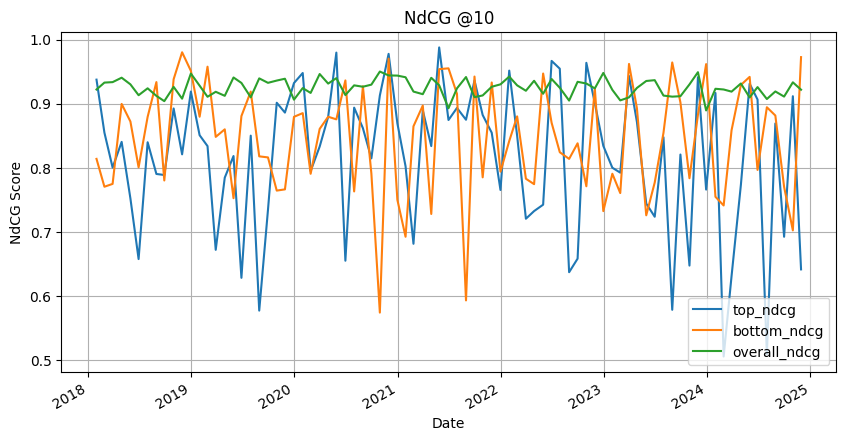

In [13]:

fig, ax = plt.subplots(figsize=(10, 5)) 
a.plot(ax=ax)  

ax.set_xlabel("Date")
ax.set_ylabel("NdCG Score") 
ax.set_title("NdCG @10")
ax.legend(loc='lower right')  
ax.grid(True)

plt.show()

# Stock Decile Portfolios

In [14]:

def long_short_portfolio_pnl(df, k,snp_ticker_df):
   
    daily_pnl = []
    dates = []
    unique_dates = df.index.get_level_values('date').unique()
    picks = pd.DataFrame(index= unique_dates)

    for date in unique_dates:
        daily_data = df.xs(date, level='date')
        daily_data = daily_data.sort_values(by='pred', ascending=False)

        long_stocks = daily_data.head(k)
        short_stocks = daily_data.tail(k)

        picks.loc[date,[f'Long_{i+1}' for i in range(k)]] = long_stocks.index.map(lambda x: snp_ticker_df[snp_ticker_df.index==x]['ticker'].iloc[0])
        picks.loc[date,[f'Short_{i+1}' for i in range(k)]] = short_stocks.index.map(lambda x: snp_ticker_df[snp_ticker_df.index==x]['ticker'].iloc[0])


        picks.loc[date,[f'Long_{i+1}_pnl' for i in range(k)]] = np.array(long_stocks['lagged_ret'])
        picks.loc[date,[f'Short_{i+1}_pnl' for i in range(k)]] = -np.array(short_stocks['lagged_ret'])

        long_pnl = long_stocks['lagged_ret'].sum()
        short_pnl = -short_stocks['lagged_ret'].sum()  

        picks.loc[date,"Long_only_pnl"] = long_pnl/(2*k)
        picks.loc[date,"Short_only_pnl"] = short_pnl/(2*k)
        picks.loc[date,'Portfolio_pnl'] = (long_pnl + short_pnl)/(2*k)

        daily_pnl.append((long_pnl + short_pnl)/(2*k))
        dates.append(date)


    avg_return = np.mean(daily_pnl)*12
    std_dev = np.std(daily_pnl)*np.sqrt(12)
    sharpe_ratio = avg_return / std_dev 

    stats =  pd.Series({
        'sharpe_ratio': sharpe_ratio,
        'avg_return': avg_return,
        'std_dev': std_dev
    })

    pnl_df = pd.DataFrame({'date': dates, 'pnl': daily_pnl})
    return pnl_df,stats,picks




In [15]:
for i in range(1,25):
    pnl_df,stats,picks = long_short_portfolio_pnl(y_test,i,snp_ticker_df)
    print(f"Sharpe Ratio of long_short@{i} is {stats.loc['sharpe_ratio']}")

Sharpe Ratio of long_short@1 is 0.6323467428874051
Sharpe Ratio of long_short@2 is 0.7121376709933157
Sharpe Ratio of long_short@3 is 1.2718614193352153
Sharpe Ratio of long_short@4 is 1.2486660853955236
Sharpe Ratio of long_short@5 is 1.4226544669844758
Sharpe Ratio of long_short@6 is 1.5270648589430373
Sharpe Ratio of long_short@7 is 1.6624108367252266
Sharpe Ratio of long_short@8 is 1.7312547795828521
Sharpe Ratio of long_short@9 is 1.8573563218888536
Sharpe Ratio of long_short@10 is 1.805185626695559
Sharpe Ratio of long_short@11 is 1.855285514128749
Sharpe Ratio of long_short@12 is 1.87596377783263
Sharpe Ratio of long_short@13 is 1.782388491543904
Sharpe Ratio of long_short@14 is 1.8191939206229921
Sharpe Ratio of long_short@15 is 1.8250650651642446
Sharpe Ratio of long_short@16 is 1.9290148473229982
Sharpe Ratio of long_short@17 is 1.8997919775049723
Sharpe Ratio of long_short@18 is 1.9516595893951532
Sharpe Ratio of long_short@19 is 1.8711819433926022
Sharpe Ratio of long_short

# Analyzing top 10 portfolio

In [24]:
pnl_df,stats,picks = long_short_portfolio_pnl(y_test,10,snp_ticker_df)
stats

sharpe_ratio    1.805186
avg_return      0.259926
std_dev         0.143989
dtype: float64

# Stocks picked by Id (count) plot

>> Long_1 Is the predicted stock with the highest return
>> Long_2 Is the predicted stock with the highest return ,Long_3  and so on..

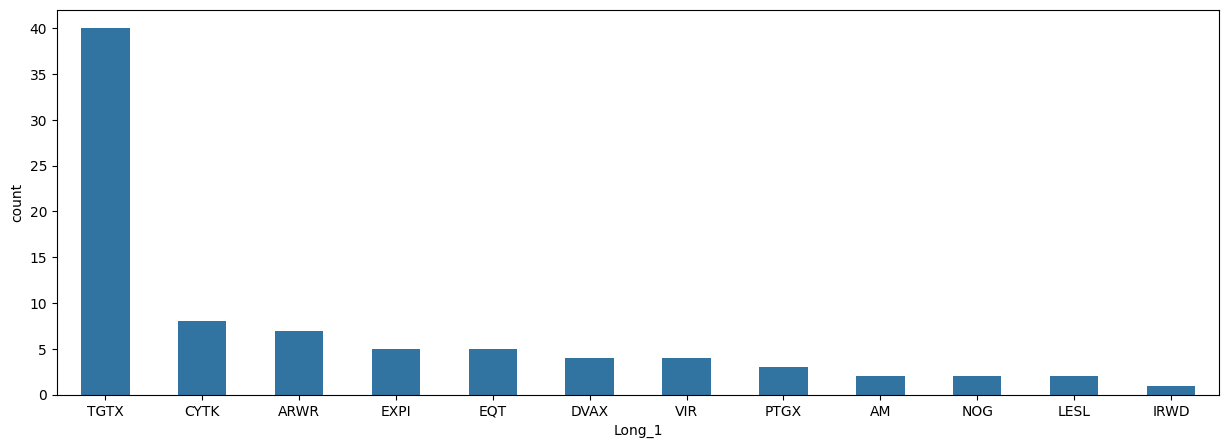

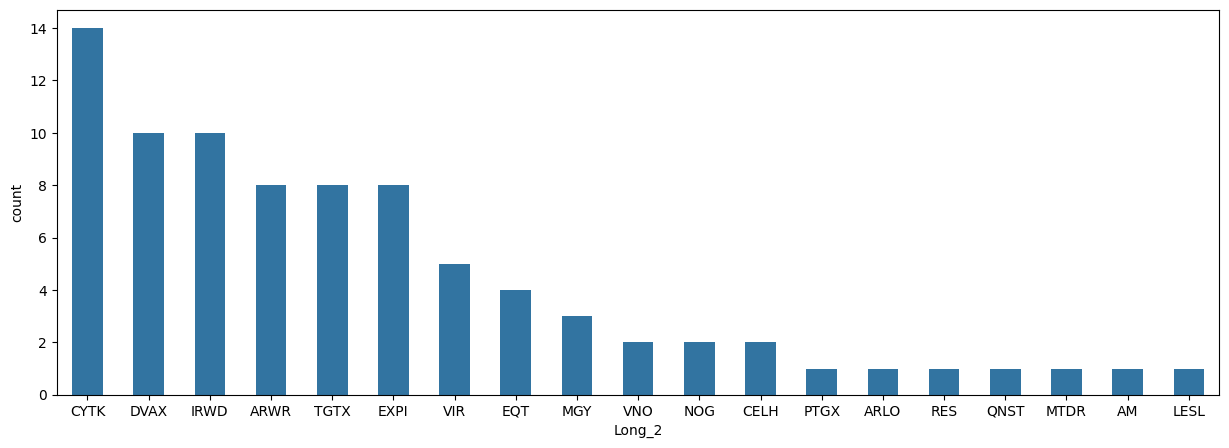

In [17]:
for i in range(1,3):
    plt.figure(figsize=(15, 5))
    sns.barplot(picks[f"Long_{i}"].value_counts(),width=0.5)

# Markets beta/IR

In [18]:
pnl_cols = [col for col in picks.columns if col.endswith("_pnl")]
def LFPM_TS(assets, factors, annualize = 12, name = 'asset', treynor = False, mkt_name = 'vwretd'):
    
    if isinstance(assets,pd.Series):
        assets = pd.DataFrame(assets,columns=name)
    
    model_output = pd.DataFrame()
    stats_output = pd.DataFrame()
    
    x = sm.add_constant(factors)
    
    for asset in assets.columns:
        
        y = assets[asset]
        model = sm.OLS(y,x).fit()
        
        model_output[asset] = model.params
        
        mu = y.mean() * annualize
        alpha = model.params[0] * annualize
        sig_ep = model.resid.std() * np.sqrt(annualize)
        IR = alpha / sig_ep
        
        stats_output[asset] = pd.Series(data = [alpha,IR],index = ['Alpha','IR'])
        
        if treynor:
            mkt = model.params[mkt_name]
            TR = mu / mkt
            
            stats_output.loc['Treynor',asset] = TR
    
    model_output = model_output.rename({"x1":'beta'})
        
    return pd.concat([model_output,stats_output],axis=0)

# making them contemperous
mkt_rets = market_df[market_df.index>=pd.to_datetime('2018-01-01')].shift(1).dropna().values
market_stats = LFPM_TS(picks[pnl_cols],mkt_rets)


/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10080/1600184353.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] * annualize
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10080/1600184353.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] * annualize
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10080/1600184353.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

In [22]:
market_stats[market_stats.columns[::-1]]

,Portfolio_pnl,Short_only_pnl,Long_only_pnl,Short_10_pnl,Short_9_pnl,Short_8_pnl,Short_7_pnl,Short_6_pnl,Short_5_pnl,Short_4_pnl,...,Long_10_pnl,Long_9_pnl,Long_8_pnl,Long_7_pnl,Long_6_pnl,Long_5_pnl,Long_4_pnl,Long_3_pnl,Long_2_pnl,Long_1_pnl
const,0.021057,-0.005237,0.026294,-0.017361,0.004817,-0.009740,-0.019003,0.001114,-0.021063,-0.000137,...,0.037717,0.069838,0.039076,0.052219,0.071570,0.045532,0.045100,0.092312,0.018621,0.053901
beta,0.053698,0.057016,-0.003318,0.152195,0.102676,0.103791,0.188822,-0.043133,0.196031,-0.008628,...,-0.949367,-0.191173,-0.408414,-0.155002,0.802312,-0.545018,1.052703,0.365777,-0.431812,0.393634
Alpha,0.252690,-0.062842,0.315532,-0.208328,0.057799,-0.116877,-0.228039,0.013373,-0.252755,-0.001644,...,0.452601,0.838058,0.468909,0.626630,0.858840,0.546388,0.541199,1.107744,0.223453,0.646809
IR,1.748009,-0.672207,1.711023,-0.672478,0.170904,-0.393812,-0.858653,0.044090,-0.917569,-0.004983,...,0.705004,1.285045,0.872255,1.013980,0.829260,0.907968,0.647862,1.328459,0.323895,0.791784


Market Neutral as expected, but exposure to other factors like size may not be zero

In [19]:


# Decile Sharpes
def stats(returns,annualize = 12, q = 0.05):

    output = returns.agg(['mean','std'])
    output.loc['sharpe'] = output.loc['mean'] / output.loc['std']
    output.loc['mean'] *= annualize
    output.loc['std'] *= np.sqrt(annualize)
    output.loc['sharpe'] *= np.sqrt(annualize)
    output.loc['skew'] = returns.skew()
    output.loc['kurtosis'] = returns.kurtosis()
    output.loc['var_%s'%q] = returns.quantile(q)
    output.loc['cvar_%s'%q] = returns[returns<= returns.quantile(q)].mean()
    return output.T
stats(picks[pnl_cols])


,mean,std,sharpe,skew,kurtosis,var_0.05,cvar_0.05
Long_1_pnl,0.699857,0.819803,0.853690,0.354212,1.167748,-0.219670,-0.386436
Long_2_pnl,0.165260,0.694025,0.238118,0.728338,0.024694,-0.213392,-0.302269
Long_3_pnl,1.157038,0.836312,1.383500,0.759041,0.586751,-0.243832,-0.282317
Long_4_pnl,0.683067,0.855453,0.798486,2.822952,14.167341,-0.208256,-0.291011
Long_5_pnl,0.472938,0.609289,0.776213,0.700062,0.455858,-0.189998,-0.225033
Long_6_pnl,0.966964,1.045153,0.925189,2.228708,7.585150,-0.281215,-0.363574
Long_7_pnl,0.605741,0.618586,0.979235,1.657843,5.681245,-0.169813,-0.202642
Long_8_pnl,0.413868,0.542317,0.763148,0.575975,0.493396,-0.179293,-0.217701
Long_9_pnl,0.812295,0.653021,1.243903,1.408423,3.420978,-0.149291,-0.206534
Long_10_pnl,0.324659,0.663154,0.489569,0.863587,0.870981,-0.201894,-0.290182


# Winrates

In [20]:

winRates= pd.DataFrame()
for i in range(1,11):
    winRates.loc[i,f"Long"] = (picks[f"Long_{i}_pnl"]>0).mean()
    winRates.loc[i,f"Short"] = (picks[f"Short_{i}_pnl"]>0).mean()

winRates.loc['All',f"Long"] = (picks[f"Long_only_pnl"]>0).mean()
winRates.loc['All',f"Short"] = (picks[f"Short_only_pnl"]>0).mean()
winRates.loc['Portfolio','Long'] = (picks['Portfolio_pnl']>0).mean()
winRates.loc['Portfolio','Short'] = (picks['Portfolio_pnl']>0).mean()

winRates

,Long,Short
1,0.530120,0.385542
2,0.445783,0.493976
3,0.602410,0.493976
4,0.626506,0.445783
5,0.518072,0.421687
6,0.578313,0.457831
7,0.590361,0.433735
8,0.530120,0.542169
9,0.590361,0.481928
10,0.481928,0.409639


# Other Portfolio Metrics

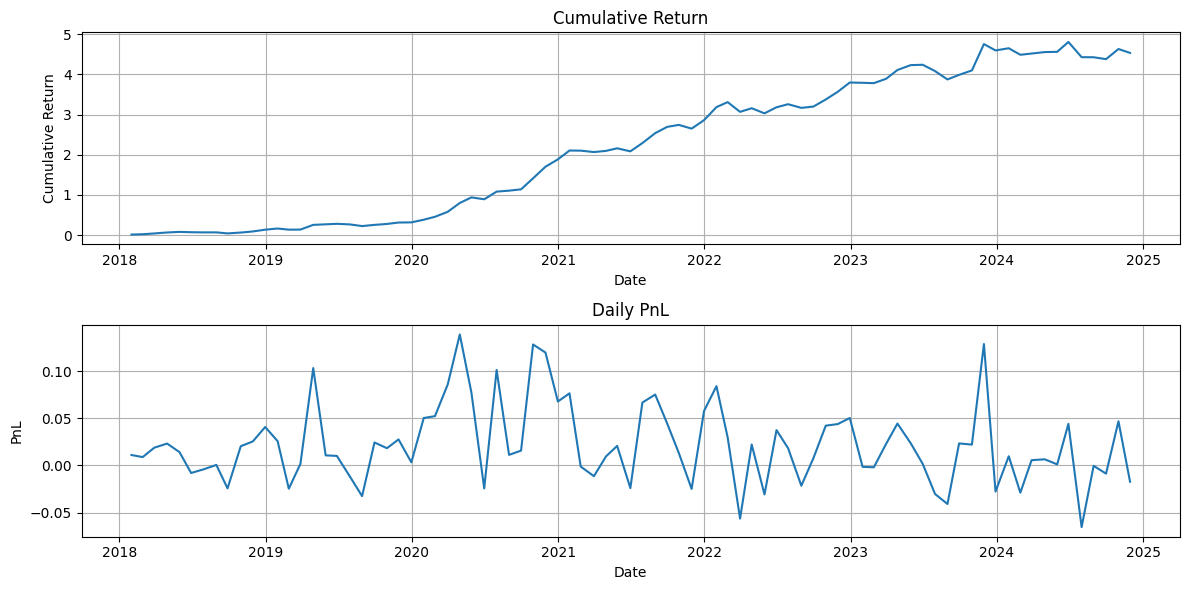

In [21]:

pnl_df['cumulative_return'] = (1 + pnl_df["pnl"].fillna(0)).cumprod() - 1
pnl_df['drawdown'] = (pnl_df['cumulative_return'] - pnl_df['cumulative_return'].cummax()) / pnl_df['cumulative_return'].cummax()
pnl_df['max_drawdown'] = pnl_df['drawdown'].min()

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(pnl_df['date'], pnl_df['cumulative_return']) 
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(pnl_df['date'], pnl_df['pnl']) 
plt.title('Daily PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)

plt.tight_layout()
plt.show()